# Projet 3 : Notebook Prediction - Energy

Après avoir traiter les données brutes, nous allons mettre en place nos modèles de Machine learning pour effectuer notre régression et la consommation en énergie de notre batiment.


In [1]:
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

In [3]:
Data = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data' )
Data_ORDENC_KNNI = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data_ORDENC_KNNI' )
Data_ORDENC_ITE = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data_ORDENC_ITE' )
Data_OHE_KNNI = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data_OHE_KNNI' )
Data_OHE_ITE = pd.read_excel( 'data_projet_3.xlsx', sheet_name = 'Data_OHE_ITE' )

# Import Bibliotèque

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score

In [5]:
from sklearn.dummy import DummyRegressor
from  sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier
from shap import summary_plot

In [6]:
pd.set_option('display.max_columns', 200)

# Milestone 2 : Développement et simulation d’un premier modèle

In [7]:
Data_OHE_KNNI.columns

Index(['Unnamed: 0', 'OSEBuildingID', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'Outlier Cat', 'Electricity(kBtu) %', 'SteamUse(kBtu) %',
       'NaturalGas(kBtu) %', 'GFA_by_floor', 'more_one_building', 'x0_ballard',
       'x0_central', 'x0_delridge', 'x0_delri

Dans cette première partie, nous allons développer notre premier modèle de machine learning.

## Test Modèle Dummy Regressor

Tout d'abord nous testons notre modèle Dummy Regressor sur les données issues du One Hot Encoder et avec une imputation par la technique des KNNImputer. Nous testerons plus tard des modèles sur toutes les données que nous avons pour pouvoir comparer nos résultats. Mais tout d'abord on test sur un seul dataset.

In [8]:
Data_OHE_KNNI = Data_OHE_KNNI.drop(columns = ['Unnamed: 0'])
Data_OHE_ITE = Data_OHE_ITE.drop(columns = ['Unnamed: 0'])

Data_OHE_KNNI = Data_OHE_KNNI.rename(columns = {"x2_Convenience Store without Gas Station, Data Center, Financial Office, Fitness Center/Health Club/Gym, Office, Other, Parking, Personal Services (Health/Beauty, Dry Cleaning, etc), Restaurant":"Convenience"})
Data_OHE_ITE = Data_OHE_ITE.rename(columns = {"x2_Convenience Store without Gas Station, Data Center, Financial Office, Fitness Center/Health Club/Gym, Office, Other, Parking, Personal Services (Health/Beauty, Dry Cleaning, etc), Restaurant":"Convenience"})

In [9]:
Data_OHE_KNNI 

,OSEBuildingID,PrimaryPropertyType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,Outlier Cat,Electricity(kBtu) %,SteamUse(kBtu) %,NaturalGas(kBtu) %,GFA_by_floor,more_one_building,x0_ballard,x0_central,x0_delridge,x0_delridge neighborhoods,x0_downtown,x0_east,x0_greater duwamish,x0_lake union,x0_magnolia / queen anne,x0_nan,x0_north,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x0_water,Log TotalGHGEmissions,Log SiteEnergyUseWN(kBtu)
0,1,0.90,7.0,47.61220,-122.33799,1927.0,1,12,88434,0.0,88434.0,0.90,88434.000000,0.4,0.0,0.40,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.50,7456910.00,2.003882e+06,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,249.98,2.830,0,0.546060,0.277302,0.176638,7370,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.521381,15.824652
1,2,0.90,7.0,47.61317,-122.33393,1996.0,1,11,103566,15064.0,88502.0,0.90,83880.000000,0.4,15064.0,0.55,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.00,8664479.00,0.000000e+00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,295.86,2.860,0,0.386609,0.000000,0.613391,9415,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.689886,15.974742
2,3,0.90,7.0,47.61393,-122.33810,1969.0,1,41,956110,196718.0,759392.0,0.90,756493.000000,0.4,0.0,0.40,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.00,73937112.00,2.156655e+07,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,2089.28,2.190,0,0.682307,0.297113,0.020579,23320,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.644575,18.118725
3,5,0.90,7.0,47.61412,-122.33664,1926.0,1,10,61320,0.0,61320.0,0.90,61320.000000,0.4,0.0,0.40,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.00,6946800.50,2.214446e+06,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,286.43,4.670,0,0.407519,0.325913,0.266567,6132,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.657494,15.753792
4,8,0.90,7.0,47.61375,-122.34047,1980.0,1,18,175580,62000.0,113580.0,0.90,123445.000000,0.4,68009.0,0.40,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.00,14656503.00,0.000000e+00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,505.01,2.880,0,0.378802,0.000000,0.621198,9754,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.224578,16.500395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,50170,0.65,5.0,47.70598,-122.33486,2016.0,1,2,44745,0.0,44745.0,0.40,44667.000000,0.4,0.0,0.40,0.0,76.0,41.600000,41.600000,130.800000,130.800000,1860094.75,1860094.75,3.515600e+03,5.451625e+05,1.860094e+06,678.968217,6.789684e+04,N,7.70,0.172,0,0.967725,0.001996,0.030279,22372,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.041220,14.436138
3097,50186,0.65,7.0,47.60039,-122.33247,2016.0,1,8,213803,24987.0,188816.0,0.65,217888.000000,0.4,0.0,0.40,0.0,99.0,28.300000,28.300000,88.900000,88.900000,6169209.00,6169209.00,6.496273e+04,1.808092e+06,6.169208e+06,2605.874029,2.605874e+05,N,25.52,0.119,0,0.964381,0.008378,0.027242,26725,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.239462,15.635081
3098,50188,0.40,7.0,47.61582,-122.34615,2016.0,1,4,95576,24184.0,71392.0,0.65,40074.898438,0.7,24853.0,0.40,24184.0,93.0,42.200000,41.500000,132.600000,130.

## Valeurs  NAN 

Il reste quelque valeurs NAN générées par les ENCODER, on les remplace par 0.

In [10]:
Data_OHE_KNNI = Data_OHE_KNNI.fillna(0)
Data_OHE_ITE = Data_OHE_ITE.fillna(0)
Data_ORDENC_KNNI = Data_ORDENC_KNNI.fillna(0)
Data_ORDENC_ITE = Data_ORDENC_ITE.fillna(0)

## Colonnes des features et colonnes Target

On crée une liste qui va composer les colonnes de nos features. On crée une deuxième liste "col_drop" qui va être composé des variables que nous allons garder dans nos features de prédiction. On supprime donc dans notre liste de features :
 - Les valeurs cibles à prédire
 - Les ID restants
 - Les données relatives aux consommations d'énergie qui vont grandement impacter les résultats.
 
Dans la colonne target on garde juste la variable "SiteEnergyUseWN(kBtu)" qui sera notre variable prédite dans ce premier notebook de prédiction.

In [11]:
col_drop =  ['TotalGHGEmissions','GHGEmissionsIntensity',"SiteEUIWN(kBtu/sf)","SiteEUI(kBtu/sf)","SiteEnergyUseWN(kBtu)","SourceEUI(kBtu/sf)","SourceEUIWN(kBtu/sf)","SiteEnergyUse(kBtu)","OSEBuildingID","DefaultData","NaturalGas(therms)","NaturalGas(kBtu)","SteamUse(kBtu)","Electricity(kBtu)",'Electricity(kWh)',"Log SiteEnergyUseWN(kBtu)",'Log TotalGHGEmissions',"Outlier Cat"]

In [12]:
Features = list(Data_OHE_KNNI.columns)

for col in    ['TotalGHGEmissions','GHGEmissionsIntensity',"SiteEUIWN(kBtu/sf)","SiteEUI(kBtu/sf)","SiteEnergyUseWN(kBtu)","SourceEUI(kBtu/sf)","SourceEUIWN(kBtu/sf)","SiteEnergyUse(kBtu)","OSEBuildingID","DefaultData","NaturalGas(therms)",'NaturalGas(kBtu)',"SteamUse(kBtu)","Electricity(kBtu)",'Electricity(kWh)','Log SiteEnergyUseWN(kBtu)','Log TotalGHGEmissions',"Outlier Cat"]:
    Features.remove(col)


On crée une autre liste où on retire des features, la variable "EnergyStarScore". On fera deux prédictions, une avec cette variable et une deuxièeme sans.

In [13]:
Features_without_nrj_stars = Features.copy()
Features_without_nrj_stars.remove('ENERGYSTARScore')

In [14]:
Features_without_nrj_stars

['PrimaryPropertyType',
 'CouncilDistrictCode',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA',
 'Electricity(kBtu) %',
 'SteamUse(kBtu) %',
 'NaturalGas(kBtu) %',
 'GFA_by_floor',
 'more_one_building',
 'x0_ballard',
 'x0_central',
 'x0_delridge',
 'x0_delridge neighborhoods',
 'x0_downtown',
 'x0_east',
 'x0_greater duwamish',
 'x0_lake union',
 'x0_magnolia / queen anne',
 'x0_nan',
 'x0_north',
 'x0_northeast',
 'x0_northwest',
 'x0_southeast',
 'x0_southwest',
 'x0_water']

In [15]:
Data_OHE_ITE[Features].head(3)

,PrimaryPropertyType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,Electricity(kBtu) %,SteamUse(kBtu) %,NaturalGas(kBtu) %,GFA_by_floor,more_one_building,x0_ballard,x0_central,x0_delridge,x0_delridge neighborhoods,x0_downtown,x0_east,x0_greater duwamish,x0_lake union,x0_magnolia / queen anne,x0_nan,x0_north,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x0_water
0,0.9,7.0,47.61220,-122.33799,1927.0,1,12,88434,0.0,88434.0,0.9,88434.0,0.4,0.0,0.40,0.0,60.0,0.546060,0.277302,0.176638,7370,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.9,7.0,47.61317,-122.33393,1996.0,1,11,103566,15064.0,88502.0,0.9,83880.0,0.4,15064.0,0.55,4622.0,61.0,0.386609,0.000000,0.613391,9415,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9,7.0,47.61393,-122.33810,1969.0,1,41,956110,196718.0,759392.0,0.9,756493.0,0.4,0.0,0.40,0.0,43.0,0.682307,0.297113,0.020579,23320,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


On crée une liste avec la valeurs cible qui est la consommation d'énergie.

In [16]:
target = ["Log SiteEnergyUseWN(kBtu)"]

In [17]:
print(f" Il y a {len(Features)} variables caractéristiques de nos données.")

 Il y a 38 variables caractéristiques de nos données.


## Test Dummy Regressor

Le dummy Regressor est un algorithme de règles simples qui va être utilisé comme base de références de comparaison avec les autres algorithmes de régression.

On crée une fonction qui permet de faire la séparation des données de test et d'entrainement.

In [18]:
def OHE_Train_Test_Split (df,T, Feat):
    
    X = df[Feat]
    Y = df[T]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2 , random_state = 100, shuffle=False)
    
    return x_train, x_test, y_train, y_test

On fait des premiers test avec une mise en place très détaillée pour voir comment fonctionne la procédure. A la suite on utilisera des fonctions qui pourront automatiser les procédures.

In [19]:
x_train, x_test, y_train, y_test = OHE_Train_Test_Split (Data_OHE_KNNI, target, Features)

dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(x_train ,y_train)
y_DR_KNNI_OHE = dummy_regr.predict(x_test)

mse = mean_squared_error(y_test, y_DR_KNNI_OHE)
rmse = np.sqrt(mean_squared_error(y_test, y_DR_KNNI_OHE))
mae = mean_absolute_error(y_test, y_DR_KNNI_OHE)
explained_var = explained_variance_score(y_test, y_DR_KNNI_OHE)
r2_score_KNN_OHE = r2_score(y_test, y_DR_KNNI_OHE)
print('Dummy regressor sur les données KNNI')
print(f'mse = {mse}\nrmse = {rmse}\nmae = {mae}\nexplained_var = {explained_var}\nr2_score_RFR = {r2_score_KNN_OHE}')


Dummy regressor sur les données KNNI
mse = 1.5260426557900368
rmse = 1.2353309903787069
mae = 1.005582158492028
explained_var = -2.220446049250313e-16
r2_score_RFR = -0.1523693269657438


Les résultats obtenus à l'aide du Dummy Regressor vont nous servir de base de comparaison. 

On obtient un R² négatif avec le Dummy Regressor ce qui montre que nos résultats avec ce modèles sont ambigus. La prédiction n'est pas de bonne qualité. On essaiera d'autres modèles pour voir si le problème vient du traitement des données.

In [20]:
Data = Data_OHE_ITE.copy()

On crée une fonction qui nous permet de récupérer les scores de modèles ainsi que son temps de fit.

In [21]:
def Parametres_scores(x):
    
    means = x.cv_results_['mean_test_score']
    stds = x.cv_results_['std_test_score']
    ranks = x.cv_results_['rank_test_score']
    means_fit_time = x.cv_results_["mean_fit_time"]

    for i, (rank, mean, std, params) in enumerate(zip(ranks, means, stds, x.cv_results_['params'])):
        print(f' Fit time: { round(means_fit_time[i],4)} MAE :{round(mean, 3)} (std : +/- {round(std*2, 3)}) for {params}')


Ci-dessous les hyper paramètres de notre modèles dummy regressor que nous allons optimiser.

In [22]:
parameters = {"strategy" : ["mean", "median", "quantile", "constant"],
              "quantile": np.arange(0.0, 1.0, 0.1)}

score_dr = {"R2 Score":"r2", "MSE" : "neg_mean_squared_error", "RMSE" : "neg_root_mean_squared_error"}
## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [23]:
Gridsearch_score = []
for n_score in "r2", "neg_root_mean_squared_error", "neg_mean_absolute_error" : 
    Dummy_Grid = GridSearchCV(estimator = DummyRegressor(), 
                          param_grid = parameters,
                          scoring = n_score,
                          cv=5,
                          verbose=3
                         )

    Dummy_Grid.fit(x_train, y_train)
    Gridsearch_score.append([Dummy_Grid,Dummy_Grid.best_params_])
    
GS_Score = {"r2": Gridsearch_score[0],"neg_root_mean_squared_error" :  Gridsearch_score[1],"neg_mean_absolute_error" :Gridsearch_score[2]  }

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......quantile=0.0, strategy=mean;, score=-0.695 total time=   0.0s
[CV 2/5] END ......quantile=0.0, strategy=mean;, score=-0.244 total time=   0.0s
[CV 3/5] END ......quantile=0.0, strategy=mean;, score=-0.950 total time=   0.0s
[CV 4/5] END ......quantile=0.0, strategy=mean;, score=-0.462 total time=   0.0s
[CV 5/5] END ......quantile=0.0, strategy=mean;, score=-0.039 total time=   0.0s
[CV 1/5] END ....quantile=0.0, strategy=median;, score=-0.907 total time=   0.0s
[CV 2/5] END ....quantile=0.0, strategy=median;, score=-0.175 total time=   0.0s
[CV 3/5] END ....quantile=0.0, strategy=median;, score=-0.878 total time=   0.0s
[CV 4/5] END ....quantile=0.0, strategy=median;, score=-0.624 total time=   0.0s
[CV 5/5] END ....quantile=0.0, strategy=median;, score=-0.014 total time=   0.0s
[CV 1/5] END .quantile=0.0, strategy=quantile;, score=-20.023 total time=   0.0s
[CV 2/5] END ..quantile=0.0, strategy=quantile;

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END ....quantile=0.1, strategy=median;, score=-0.907 total time=   0.0s
[CV 2/5] END ....quantile=0.1, strategy=median;, score=-0.175 total time=   0.0s
[CV 3/5] END ....quantile=0.1, strategy=median;, score=-0.878 total time=   0.0s
[CV 4/5] END ....quantile=0.1, strategy=median;, score=-0.624 total time=   0.0s
[CV 5/5] END ....quantile=0.1, strategy=median;, score=-0.014 total time=   0.0s
[CV 1/5] END ..quantile=0.1, strategy=quantile;, score=-4.458 total time=   0.0s
[CV 2/5] END ..quantile=0.1, strategy=quantile;, score=-0.771 total time=   0.0s
[CV 3/5] END ..quantile=0.1, strategy=quantile;, score=-0.366 total time=   0.0s
[CV 4/5] END ..quantile=0.1, strategy=quantile;, score=-3.542 total time=   0.0s
[CV 5/5] END ..quantile=0.1, strategy=quantile;, score=-1.281 total time=   0.0s
[CV 1/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END ..quantile=0.2, strategy=quantile;, score=-2.907 total time=   0.0s
[CV 2/5] END ..quantile=0.2, strategy=quantile;, score=-0.227 total time=   0.0s
[CV 3/5] END ..quantile=0.2, strategy=quantile;, score=-0.012 total time=   0.0s
[CV 4/5] END ..quantile=0.2, strategy=quantile;, score=-2.252 total time=   0.0s
[CV 5/5] END ..quantile=0.2, strategy=quantile;, score=-0.554 total time=   0.0s
[CV 1/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=mean;, score=-0.695 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=mean;, score=-0.244 total time=   0.0s
[CV 3/5]

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END quantile=0.30000000000000004, strategy=quantile;, score=-2.080 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.027 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.072 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.564 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.199 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.4, strategy=mean;, score=-0.695 tot

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 


[CV 1/5] END ....quantile=0.4, strategy=median;, score=-0.907 total time=   0.0s
[CV 2/5] END ....quantile=0.4, strategy=median;, score=-0.175 total time=   0.0s
[CV 3/5] END ....quantile=0.4, strategy=median;, score=-0.878 total time=   0.0s
[CV 4/5] END ....quantile=0.4, strategy=median;, score=-0.624 total time=   0.0s
[CV 5/5] END ....quantile=0.4, strategy=median;, score=-0.014 total time=   0.0s
[CV 1/5] END ..quantile=0.4, strategy=quantile;, score=-1.445 total time=   0.0s
[CV 2/5] END ..quantile=0.4, strategy=quantile;, score=-0.016 total time=   0.0s
[CV 3/5] END ..quantile=0.4, strategy=quantile;, score=-0.329 total time=   0.0s
[CV 4/5] END ..quantile=0.4, strategy=quantile;, score=-1.044 total time=   0.0s
[CV 5/5] END ..quantile=0.4, strategy=quantile;, score=-0.031 total time=   0.0s
[CV 1/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 2/5] END ..quantile=0.5, strategy=quantile;, score=-0.175 total time=   0.0s
[CV 3/5] END ..quantile=0.5, strategy=quantile;, score=-0.878 total time=   0.0s
[CV 4/5] END ..quantile=0.5, strategy=quantile;, score=-0.624 total time=   0.0s
[CV 5/5] END ..quantile=0.5, strategy=quantile;, score=-0.014 total time=   0.0s
[CV 1/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=mean;, score=-0.695 total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=mean;, score=-0.244 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=mean;, score=-0.950 total time=   0.0s
[

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 2/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.564 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.609 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.281 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.199 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=mean;, score=-0.695 total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=mean;, score=-0.244 total ti

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 2/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.164 total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=quantile;, score=-2.627 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=quantile;, score=-0.031 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=quantile;, score=-0.621 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.8, strategy=mean;, score=-0.695 total time=   0.0s
[CV 2/5] END ......quantile=0.8, strategy=mean;, score=-0.244 total time=   0.0s
[CV 3/5

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END ....quantile=0.8, strategy=median;, score=-0.624 total time=   0.0s
[CV 5/5] END ....quantile=0.8, strategy=median;, score=-0.014 total time=   0.0s
[CV 1/5] END ..quantile=0.8, strategy=quantile;, score=-0.010 total time=   0.0s
[CV 2/5] END ..quantile=0.8, strategy=quantile;, score=-2.203 total time=   0.0s
[CV 3/5] END ..quantile=0.8, strategy=quantile;, score=-4.348 total time=   0.0s
[CV 4/5] END ..quantile=0.8, strategy=quantile;, score=-0.042 total time=   0.0s
[CV 5/5] END ..quantile=0.8, strategy=quantile;, score=-1.332 total time=   0.0s
[CV 1/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END ......quantile=0.9, strategy=mean;, score=-0.950 total time=   0.0s
[CV 4/5] END ......quantile=0.9, strategy=mean;, score=-0.462 total time=   0.0s
[CV 5/5] END ......quantile=0.9, strategy=mean;, score=-0.039 total time=   0.0s
[CV 1/5] END ....quantile=0.9, strategy=median;, score=-0.907 total time=   0.0s
[CV 2/5] END ....quantile=0.9, strategy=median;, score=-0.175 total time=   0.0s
[CV 3/5] END ....quantile=0.9, strategy=median;, score=-0.878 total time=   0.0s
[CV 4/5] END ....quantile=0.9, strategy=median;, score=-0.624 total time=   0.0s
[CV 5/5] END ....quantile=0.9, strategy=median;, score=-0.014 total time=   0.0s
[CV 1/5] END ..quantile=0.9, strategy=quantile;, score=-0.434 total time=   0.0s
[CV 2/5] END ..quantile=0.9, strategy=quantile;, score=-4.105 total time=   0.0s
[CV 3/5] END ..quantile=0.9, strategy=quantile;, score=-7.149 total time=   0.0s
[CV 4/5] END ..quantile=0.9, strategy=quantile;, score=-0.527 total time=   0.0s
[CV 5/5] END ..quantile=0.9,

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 2/5] END ....quantile=0.0, strategy=median;, score=-1.175 total time=   0.0s
[CV 3/5] END ....quantile=0.0, strategy=median;, score=-1.298 total time=   0.0s
[CV 4/5] END ....quantile=0.0, strategy=median;, score=-1.458 total time=   0.0s
[CV 5/5] END ....quantile=0.0, strategy=median;, score=-1.113 total time=   0.0s
[CV 1/5] END ..quantile=0.0, strategy=quantile;, score=-4.940 total time=   0.0s
[CV 2/5] END ..quantile=0.0, strategy=quantile;, score=-3.526 total time=   0.0s
[CV 3/5] END ..quantile=0.0, strategy=quantile;, score=-3.495 total time=   0.0s
[CV 4/5] END ..quantile=0.0, strategy=quantile;, score=-4.861 total time=   0.0s
[CV 5/5] END ..quantile=0.0, strategy=quantile;, score=-4.081 total time=   0.0s
[CV 1/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END ....quantile=0.1, strategy=median;, score=-1.458 total time=   0.0s
[CV 5/5] END ....quantile=0.1, strategy=median;, score=-1.113 total time=   0.0s
[CV 1/5] END ..quantile=0.1, strategy=quantile;, score=-2.517 total time=   0.0s
[CV 2/5] END ..quantile=0.1, strategy=quantile;, score=-1.442 total time=   0.0s
[CV 3/5] END ..quantile=0.1, strategy=quantile;, score=-1.107 total time=   0.0s
[CV 4/5] END ..quantile=0.1, strategy=quantile;, score=-2.438 total time=   0.0s
[CV 5/5] END ..quantile=0.1, strategy=quantile;, score=-1.670 total time=   0.0s
[CV 1/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 5/5] END ......quantile=0.2, strategy=mean;, score=-1.127 total time=   0.0s
[CV 1/5] END ....quantile=0.2, strategy=median;, score=-1.488 total time=   0.0s
[CV 2/5] END ....quantile=0.2, strategy=median;, score=-1.175 total time=   0.0s
[CV 3/5] END ....quantile=0.2, strategy=median;, score=-1.298 total time=   0.0s
[CV 4/5] END ....quantile=0.2, strategy=median;, score=-1.458 total time=   0.0s
[CV 5/5] END ....quantile=0.2, strategy=median;, score=-1.113 total time=   0.0s
[CV 1/5] END ..quantile=0.2, strategy=quantile;, score=-2.130 total time=   0.0s
[CV 2/5] END ..quantile=0.2, strategy=quantile;, score=-1.200 total time=   0.0s
[CV 3/5] END ..quantile=0.2, strategy=quantile;, score=-0.953 total time=   0.0s
[CV 4/5] END ..quantile=0.2, strategy=quantile;, score=-2.063 total time=   0.0s
[CV 5/5] END ..quantile=0.2, strategy=quantile;, score=-1.378 total time=   0.0s
[CV 1/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END quantile=0.30000000000000004, strategy=median;, score=-1.458 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=median;, score=-1.113 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.891 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.098 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.981 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.832 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.211 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=constant;, 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END ..quantile=0.4, strategy=quantile;, score=-1.092 total time=   0.0s
[CV 4/5] END ..quantile=0.4, strategy=quantile;, score=-1.635 total time=   0.0s
[CV 5/5] END ..quantile=0.4, strategy=quantile;, score=-1.123 total time=   0.0s
[CV 1/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.5, strategy=mean;, score=-1.403 total time=   0.0s
[CV 2/5] END ......quantile=0.5, strategy=mean;, score=-1.209 total time=   0.0s
[CV 3/5] END ......quantile=0.5, strategy=mean;, score=-1.323 total time=   0.0s
[CV 4/5] END ......quantile=0.5, strategy=mean;, score=-1.383 total time=   0.0s
[CV 5/5] END ......quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END ....quantile=0.5, strategy=median;, score=-1.298 total time=   0.0s
[CV 4/5] END ....quantile=0.5, strategy=median;, score=-1.458 total time=   0.0s
[CV 5/5] END ....quantile=0.5, strategy=median;, score=-1.113 total time=   0.0s
[CV 1/5] END ..quantile=0.5, strategy=quantile;, score=-1.488 total time=   0.0s
[CV 2/5] END ..quantile=0.5, strategy=quantile;, score=-1.175 total time=   0.0s
[CV 3/5] END ..quantile=0.5, strategy=quantile;, score=-1.298 total time=   0.0s
[CV 4/5] END ..quantile=0.5, strategy=quantile;, score=-1.458 total time=   0.0s
[CV 5/5] END ..quantile=0.5, strategy=quantile;, score=-1.113 total time=   0.0s
[CV 1/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END quantile=0.6000000000000001, strategy=median;, score=-1.458 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=median;, score=-1.113 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.296 total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.355 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.530 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.295 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.211 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=constant;, score=nan t

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END quantile=0.7000000000000001, strategy=median;, score=-1.298 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=median;, score=-1.458 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=median;, score=-1.113 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.126 total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.594 total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.804 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.162 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.407 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=constant;, score=nan 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END ......quantile=0.8, strategy=mean;, score=-1.383 total time=   0.0s
[CV 5/5] END ......quantile=0.8, strategy=mean;, score=-1.127 total time=   0.0s
[CV 1/5] END ....quantile=0.8, strategy=median;, score=-1.488 total time=   0.0s
[CV 2/5] END ....quantile=0.8, strategy=median;, score=-1.175 total time=   0.0s
[CV 3/5] END ....quantile=0.8, strategy=median;, score=-1.298 total time=   0.0s
[CV 4/5] END ....quantile=0.8, strategy=median;, score=-1.458 total time=   0.0s
[CV 5/5] END ....quantile=0.8, strategy=median;, score=-1.113 total time=   0.0s
[CV 1/5] END ..quantile=0.8, strategy=quantile;, score=-1.083 total time=   0.0s
[CV 2/5] END ..quantile=0.8, strategy=quantile;, score=-1.939 total time=   0.0s
[CV 3/5] END ..quantile=0.8, strategy=quantile;, score=-2.190 total time=   0.0s
[CV 4/5] END ..quantile=0.8, strategy=quantile;, score=-1.167 total time=   0.0s
[CV 5/5] END ..quantile=0.8, strategy=quantile;, score=-1.688 total time=   0.0s
[CV 1/5] END .....quantile=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END ..quantile=0.9, strategy=quantile;, score=-1.290 total time=   0.0s
[CV 2/5] END ..quantile=0.9, strategy=quantile;, score=-2.449 total time=   0.0s
[CV 3/5] END ..quantile=0.9, strategy=quantile;, score=-2.704 total time=   0.0s
[CV 4/5] END ..quantile=0.9, strategy=quantile;, score=-1.414 total time=   0.0s
[CV 5/5] END ..quantile=0.9, strategy=quantile;, score=-2.194 total time=   0.0s
[CV 1/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......quantile=0.0, strategy=mean;, score=-1.134 total time=   0.0s
[CV 2/5] END ......quantile=0.0, strategy=mean;

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 2/5] END ..quantile=0.0, strategy=quantile;, score=-3.357 total time=   0.0s
[CV 3/5] END ..quantile=0.0, strategy=quantile;, score=-3.364 total time=   0.0s
[CV 4/5] END ..quantile=0.0, strategy=quantile;, score=-4.725 total time=   0.0s
[CV 5/5] END ..quantile=0.0, strategy=quantile;, score=-3.929 total time=   0.0s
[CV 1/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.0, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.1, strategy=mean;, score=-1.134 total time=   0.0s
[CV 2/5] END ......quantile=0.1, strategy=mean;, score=-0.987 total time=   0.0s
[CV 3/5] END ......quantile=0.1, strategy=mean;, score=-1.113 total time=   0.0s
[CV 4/5] END ......quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 


[CV 3/5] END ....quantile=0.1, strategy=median;, score=-1.087 total time=   0.0s
[CV 4/5] END ....quantile=0.1, strategy=median;, score=-1.195 total time=   0.0s
[CV 5/5] END ....quantile=0.1, strategy=median;, score=-0.889 total time=   0.0s
[CV 1/5] END ..quantile=0.1, strategy=quantile;, score=-2.294 total time=   0.0s
[CV 2/5] END ..quantile=0.1, strategy=quantile;, score=-1.157 total time=   0.0s
[CV 3/5] END ..quantile=0.1, strategy=quantile;, score=-0.854 total time=   0.0s
[CV 4/5] END ..quantile=0.1, strategy=quantile;, score=-2.182 total time=   0.0s
[CV 5/5] END ..quantile=0.1, strategy=quantile;, score=-1.367 total time=   0.0s
[CV 1/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.1, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END ..quantile=0.2, strategy=quantile;, score=-0.703 total time=   0.0s
[CV 4/5] END ..quantile=0.2, strategy=quantile;, score=-1.791 total time=   0.0s
[CV 5/5] END ..quantile=0.2, strategy=quantile;, score=-1.078 total time=   0.0s
[CV 1/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.2, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=mean;, score=-1.134 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=mean;, score=-0.987 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=mean;, score=-1.113 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=mean;, score=-1.126 total t

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END quantile=0.30000000000000004, strategy=median;, score=-1.195 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=median;, score=-0.889 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.631 total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.837 total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.749 total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=quantile;, score=-1.555 total time=   0.0s
[CV 5/5] END quantile=0.30000000000000004, strategy=quantile;, score=-0.934 total time=   0.0s
[CV 1/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.30000000000000004, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.30000000000000004, strategy=constant;, 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END ....quantile=0.4, strategy=median;, score=-1.195 total time=   0.0s
[CV 5/5] END ....quantile=0.4, strategy=median;, score=-0.889 total time=   0.0s
[CV 1/5] END ..quantile=0.4, strategy=quantile;, score=-1.417 total time=   0.0s
[CV 2/5] END ..quantile=0.4, strategy=quantile;, score=-0.853 total time=   0.0s
[CV 3/5] END ..quantile=0.4, strategy=quantile;, score=-0.871 total time=   0.0s
[CV 4/5] END ..quantile=0.4, strategy=quantile;, score=-1.364 total time=   0.0s
[CV 5/5] END ..quantile=0.4, strategy=quantile;, score=-0.870 total time=   0.0s
[CV 1/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.4, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END ..quantile=0.5, strategy=quantile;, score=-1.087 total time=   0.0s
[CV 4/5] END ..quantile=0.5, strategy=quantile;, score=-1.195 total time=   0.0s
[CV 5/5] END ..quantile=0.5, strategy=quantile;, score=-0.889 total time=   0.0s
[CV 1/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.5, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=mean;, score=-1.134 total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=mean;, score=-0.987 total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=mean;, score=-1.113 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=mean;, score=-1.126 total time=

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 3/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.329 total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=quantile;, score=-1.044 total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=quantile;, score=-0.997 total time=   0.0s
[CV 1/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END quantile=0.6000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=mean;, score=-1.134 total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=mean;, score=-0.987 total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=mean;, score=-1.113 total time= 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 2/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.349 total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.610 total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=quantile;, score=-0.926 total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=quantile;, score=-1.179 total time=   0.0s
[CV 1/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END quantile=0.7000000000000001, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.8, strategy=mean;, score=-1.134 total time=   0.0s
[CV 2/5] END ......quantile=0.8, strategy=mean;, score=-0.987 total time=   0.0s
[CV 3/5

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 4/5] END ..quantile=0.8, strategy=quantile;, score=-0.934 total time=   0.0s
[CV 5/5] END ..quantile=0.8, strategy=quantile;, score=-1.446 total time=   0.0s
[CV 1/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.8, strategy=constant;, score=nan total time=   0.0s
[CV 1/5] END ......quantile=0.9, strategy=mean;, score=-1.134 total time=   0.0s
[CV 2/5] END ......quantile=0.9, strategy=mean;, score=-0.987 total time=   0.0s
[CV 3/5] END ......quantile=0.9, strategy=mean;, score=-1.113 total time=   0.0s
[CV 4/5] END ......quantile=0.9, strategy=mean;, score=-1.126 total time=   0.0s
[CV 5/5] END ......quantile=0.9, strategy=mean;, score=-0.909 total time=   0.0s
[CV 1/5] END ....quantile=0.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

[CV 1/5] END ..quantile=0.9, strategy=quantile;, score=-1.053 total time=   0.0s
[CV 2/5] END ..quantile=0.9, strategy=quantile;, score=-2.217 total time=   0.0s
[CV 3/5] END ..quantile=0.9, strategy=quantile;, score=-2.538 total time=   0.0s
[CV 4/5] END ..quantile=0.9, strategy=quantile;, score=-1.151 total time=   0.0s
[CV 5/5] END ..quantile=0.9, strategy=quantile;, score=-1.951 total time=   0.0s
[CV 1/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 2/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 3/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 4/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s
[CV 5/5] END .....quantile=0.9, strategy=constant;, score=nan total time=   0.0s


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target value has to be specified "
TypeError: Constant target value has to be specified when the constant strategy is used.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\dummy.py", line 516, in fit
    raise TypeError("Constant target 

In [24]:
print(f" Les Hyperparamètres optimisés de notre modèle sont : {GS_Score['r2' ][1]}")

 Les Hyperparamètres optimisés de notre modèle sont : {'quantile': 0.0, 'strategy': 'mean'}


In [25]:
Parametres_scores(Dummy_Grid)

 Fit time: 0.0049 MAE :-1.054 (std : +/- 0.18) for {'quantile': 0.0, 'strategy': 'mean'}
 Fit time: 0.0094 MAE :-1.068 (std : +/- 0.259) for {'quantile': 0.0, 'strategy': 'median'}
 Fit time: 0.0067 MAE :-4.039 (std : +/- 1.27) for {'quantile': 0.0, 'strategy': 'quantile'}
 Fit time: 0.0057 MAE :nan (std : +/- nan) for {'quantile': 0.0, 'strategy': 'constant'}
 Fit time: 0.0084 MAE :-1.054 (std : +/- 0.18) for {'quantile': 0.1, 'strategy': 'mean'}
 Fit time: 0.0079 MAE :-1.068 (std : +/- 0.259) for {'quantile': 0.1, 'strategy': 'median'}
 Fit time: 0.0082 MAE :-1.571 (std : +/- 1.14) for {'quantile': 0.1, 'strategy': 'quantile'}
 Fit time: 0.0083 MAE :nan (std : +/- nan) for {'quantile': 0.1, 'strategy': 'constant'}
 Fit time: 0.009 MAE :-1.054 (std : +/- 0.18) for {'quantile': 0.2, 'strategy': 'mean'}
 Fit time: 0.0057 MAE :-1.068 (std : +/- 0.259) for {'quantile': 0.2, 'strategy': 'median'}
 Fit time: 0.0083 MAE :-1.275 (std : +/- 0.949) for {'quantile': 0.2, 'strategy': 'quantile'}


# Lasso

On met en place notre premier modèle de prédiction

In [26]:
parameters_lasso = {
                    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                     "tol" : [0.1,0.01,0.001,0.0001] ,
                     "random_state" : [0] ,
                    "selection" : ["cyclic", "random"]
                   }

On crée une fonction qui va prendre en entrée le Modèle, les paramètres, le score d'optimisation du GridSearch, le DataFrame, les colonnes targets et les caractéristiques. La fonction va donner en sortie le model, la meilleur configuration des hyperparamètres ainsi que les scores de l'optimisation .

In [27]:
def model_ml_HP (model, params, n_score, df, T, Feat) :
    
    """
    Optimisation des hyperparamètres 
    
    Args :
    - Model : Modèle à entrainer
    - Params : Les hyperparamètres à optimiser
    - N_Score : Le score à optimiser
    - T : Liste des targets
    - Feat : Liste des features
    
    Return :
    - Dictionnaire avec le modèle, les hyperparamètres et les scores.
    
    """
    
    x_train, x_test, y_train, y_test = OHE_Train_Test_Split (df, T, Feat)
    model_ = GridSearchCV(estimator = model, 
                          param_grid = params,
                          scoring = n_score,
                          refit = True,
                          cv=5 ,
                          verbose=3
                         )

    model_.fit(x_train, y_train)
    
    Gridsearch_score = {"model" :[model_], "Best Params" : [model_.best_params_], "Params Score" : [Parametres_scores(model_)]}

    
    return Gridsearch_score 

In [28]:
lasso_grid = model_ml_HP(Lasso(), parameters_lasso,"r2" ,Data_OHE_KNNI, target, Features )

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.160 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 631.3495129625369, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 633.616897758906, tolerance: 298.6821394117646


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.152 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.5882631836464, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.8784071358862, tolerance: 279.4053682957482


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-62.043 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.5654325998073, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 631.3495129625369, tolerance: 27.870079892403155


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.160 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 633.616897758906, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.5882631836464, tolerance: 28.99976348940089


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.152 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.8784071358862, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.5654325998073, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-62.043 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.160 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 631.3495129625369, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 633.616897758906, tolerance: 2.9868213941176456


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.152 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.5882631836464, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.8784071358862, tolerance: 2.7940536829574816


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-62.043 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.5654325998073, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 631.3495129625369, tolerance: 0.27870079892403155


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.160 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 633.616897758906, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.5882631836464, tolerance: 0.2899976348940089


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.152 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.8784071358862, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.5654325998073, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.679291013294, tolerance: 278.7007989240316


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-62.043 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.160 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 651.1192033403145, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.3753536157288, tolerance: 289.9976348940089


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.153 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.1508662937736, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.6215152870072, tolerance: 305.7987789163949


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-62.151 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.160 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.679291013294, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 651.1192033403145, tolerance: 29.868213941176457


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.153 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.3753536157288, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.1508662937736, tolerance: 27.940536829574818


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-62.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.6215152870072, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.679291013294, tolerance: 2.7870079892403155


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.160 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 651.1192033403145, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.3753536157288, tolerance: 2.899976348940089


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.153 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.1508662937736, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.6215152870072, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.679291013294, tolerance: 0.27870079892403155


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-62.151 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.160 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 651.1192033403145, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.3753536157288, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.1508662937736, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.153 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-62.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.6215152870072, tolerance: 0.3057987789163949


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.177 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.311 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.154 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.71644919514745, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 494.7228294572137, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.8788876697786, tolerance: 279.4053682957482


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.393 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.444 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.2296091963802, tolerance: 305.7987789163949


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.177 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.311 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.71644919514745, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 494.7228294572137, tolerance: 28.99976348940089


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.154 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.393 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.8788876697786, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.2296091963802, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.444 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.77213337565513, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.71644919514745, tolerance: 2.9868213941176456


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.177 total time=   0.1s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.311 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 494.7228294572137, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.8788876697786, tolerance: 2.7940536829574816


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.154 total time=   0.1s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.393 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.2296091963802, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.77213337565513, tolerance: 0.27870079892403155


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.444 total time=   0.1s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.177 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 496.71644919514745, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 494.7228294572137, tolerance: 0.2899976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.311 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.154 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.8788876697786, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.2296091963802, tolerance: 0.3057987789163949


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.393 total time=   0.1s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.444 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.1824057255973, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.9826545204061, tolerance: 298.6821394117646


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.177 total time=   0.1s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.311 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 690.1592036103123, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 674.6803192636544, tolerance: 279.4053682957482


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.154 total time=   0.1s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.393 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.7179608987174, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.1824057255973, tolerance: 27.870079892403155


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.444 total time=   0.1s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.177 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.9826545204061, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 690.1592036103123, tolerance: 28.99976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.311 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.154 total time=   0.1s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.393 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 674.6803192636544, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.7179608987174, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.444 total time=   0.1s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.177 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.1824057255973, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.9826545204061, tolerance: 2.9868213941176456


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.311 total time=   0.1s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.154 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 690.1592036103123, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 674.6803192636544, tolerance: 2.7940536829574816


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.393 total time=   0.1s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.444 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.7179608987174, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.1824057255973, tolerance: 0.27870079892403155


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.177 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.311 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 663.9826545204061, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 690.1592036103123, tolerance: 0.2899976348940089


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.154 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.393 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 674.6803192636544, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 694.7179608987174, tolerance: 0.3057987789163949


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.444 total time=   0.1s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.259 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.288 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.108 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.44768825570895, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 761.9307168854756, tolerance: 305.7987789163949


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.359 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.259 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.94885229883084, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.63975281126659, tolerance: 28.99976348940089


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.108 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.359 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.44768825570895, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 761.9307168854756, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.259 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.94885229883084, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.63975281126659, tolerance: 2.899976348940089


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.288 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.108 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.44768825570895, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 761.9307168854756, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.359 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.458 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6381772559109322, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.94885229883084, tolerance: 0.2986821394117646


[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.259 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 90.63975281126659, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 465.44768825570895, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.108 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.359 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 761.9307168854756, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.8061510322412, tolerance: 278.7007989240316


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.259 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.6640294511949, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 747.747478295556, tolerance: 289.9976348940089


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.288 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.108 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.8011820542453, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.3678642799002, tolerance: 305.7987789163949


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.359 total time=   0.1s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.458 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.8061510322412, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.6640294511949, tolerance: 29.868213941176457


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.259 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 747.747478295556, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.8011820542453, tolerance: 27.940536829574818


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.108 total time=   0.1s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.359 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.3678642799002, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.8061510322412, tolerance: 2.7870079892403155


[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.259 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.6640294511949, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 747.747478295556, tolerance: 2.899976348940089


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.288 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.108 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.8011820542453, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.3678642799002, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.359 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.458 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.8061510322412, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.6640294511949, tolerance: 0.2986821394117646


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.259 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 747.747478295556, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.8011820542453, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.3678642799002, tolerance: 0.3057987789163949


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.108 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.359 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.198 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.204 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=-0.059 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.290 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.405 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.993541144792, tolerance: 305.7987789163949


[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.198 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.204 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=-0.059 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.290 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.170011556605914, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.993541144792, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.405 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.198 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.204 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=-0.059 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.170011556605914, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.993541144792, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.290 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.405 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.198 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.204 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6274481444577305, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7837504812873703, tolerance: 0.2899976348940089


[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.059 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.290 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.170011556605914, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.993541144792, tolerance: 0.3057987789163949


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.405 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.198 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.1358154448883, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 746.2516534651426, tolerance: 298.6821394117646


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.204 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=-0.059 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.0065588208806, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 772.1874103435277, tolerance: 279.4053682957482


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.290 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.405 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 838.5183605792904, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.1358154448883, tolerance: 27.870079892403155


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.198 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.204 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 746.2516534651426, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.0065588208806, tolerance: 28.99976348940089


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=-0.059 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.290 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 772.1874103435277, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 838.5183605792904, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.405 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.198 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.1358154448883, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 746.2516534651426, tolerance: 2.9868213941176456


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.204 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=-0.059 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.0065588208806, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 772.1874103435277, tolerance: 2.7940536829574816


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.290 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.405 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 838.5183605792904, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.1358154448883, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 746.2516534651426, tolerance: 0.2986821394117646


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.198 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.204 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=-0.059 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.0065588208806, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 772.1874103435277, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 838.5183605792904, tolerance: 0.3057987789163949


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.290 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.405 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.222 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.148 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.214 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.3198570201019, tolerance: 305.7987789163949


[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.393 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.222 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.148 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.214 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.393 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.3198570201019, tolerance: 30.57987789163949


[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.222 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=-0.148 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.214 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.393 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.131 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.3198570201019, tolerance: 3.057987789163949


[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.222 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.148 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.214 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 472.3198570201019, tolerance: 0.3057987789163949


[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.393 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.222 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.148 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.214 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.393 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 832.70110350939, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.31874741657907, tolerance: 27.870079892403155


[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.131 total time=   0.1s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.222 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.9401135825507, tolerance: 29.868213941176457


[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.148 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.214 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.59999026367348, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 832.70110350939, tolerance: 30.57987789163949


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.393 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.131 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.31874741657907, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.9401135825507, tolerance: 2.9868213941176456


[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.222 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.148 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8782443429231535, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.59999026367348, tolerance: 2.7940536829574816


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.214 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.393 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 832.70110350939, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.31874741657907, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.9401135825507, tolerance: 0.2986821394117646


[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.222 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.8782443429231535, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 192.59999026367348, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 832.70110350939, tolerance: 0.3057987789163949


[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.148 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.214 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.393 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] E

Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 30.57987789163949


[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.106 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 3.057987789163949


[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.342 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 0.3057987789163949


[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.342 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.53136689703877, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.589383630004477, tolerance: 2.9868213941176456


[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.106 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.53136689703877, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7831348230151889, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.589383630004477, tolerance: 0.2986821394117646


[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.342 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 478.53136689703877, tolerance: 0.3057987789163949


[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.199 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.201 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.341 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.110 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.198 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.202 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.342 total time=   0.0s
[CV

Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.5779075968909, tolerance: 368.2991041840745


In [29]:
print(f" Les Hyperparamètres optimisés de notre modèles sont : {lasso_grid['Best Params']}")

 Les Hyperparamètres optimisés de notre modèles sont : [{'alpha': 0.001, 'random_state': 0, 'selection': 'cyclic', 'tol': 0.1}]


In [30]:
lasso_grid["model"]

[GridSearchCV(cv=5, estimator=Lasso(),
              param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'random_state': [0], 'selection': ['cyclic', 'random'],
                          'tol': [0.1, 0.01, 0.001, 0.0001]},
              scoring='r2', verbose=3)]

## Test Modèle lasso Hyperparamètres

On utilise les hyperparamètres dans notre modèle.

In [31]:
model_lasso = Lasso(alpha = 0.001, random_state =  0, tol =  0.1, selection = 'cyclic')

On crée une fonction avec le modèles, paramètres, le df, la cible, les caractèristiques ainsi que le nom qu'on va attribuer à notre modèle en entrée. La fonction nous donne en sortie un dictionnaire qui va nous indiquer les scores ainsi que les prédictions du modèle.

In [32]:
def Modele_ML (model, df, Target, Feats, Nom) :
    
    """
    Fonction permettant de déterminer les scores du modèle
    
    Arg :
    - Model : Modèle avec ses hyperparamètres
    - df : DataFrame
    - Target : Les cibles à prédire sous forme de liste
    - Feats : Liste des features
    - Nom : Nom du modèle (Servir pour le dictionnaire)
    
    Return :
    Les métrics du modèle ainsi que les valeurs prédites
    
    """
    
    x_train, x_test, y_train, y_test = OHE_Train_Test_Split (df, Target, Feats)
    Model = model
    training_start = time.perf_counter()
    Model.fit(x_train ,y_train)
    training_end = time.perf_counter()   
    y_Predict = Model.predict(x_test)
    

    mse = mean_squared_error(np.exp(y_test), np.exp(y_Predict))
    rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_Predict)))
    mae = mean_absolute_error(np.exp(y_test), np.exp(y_Predict))
    explained_var = explained_variance_score(y_test, y_Predict)
    r2_score_model = r2_score(y_test, y_Predict)
    cross_score = cross_val_score( Model, df[Feats], df[Target], cv=5, scoring="r2")

    
    print(f'mse = {mse}\nrmse = {rmse}\nmae = {mae}\nexplained_var = {explained_var}\nr2_score = {r2_score_model}\ncross_validation_score {cross_score} ')
    
    model_resume = { 
                    'Model':[Nom],
                    'Mse' : [round(mse,2)], 
                    'Rmse': [round(rmse,2)], 
                    'Mae' : [round(mae,2)], 
                    'Explained_var':[round(explained_var,2)], 
                    'R2_score' :   [round(r2_score_model,4)],
                    'Time Fit' : [training_end - training_start],
                    
                    'Cross validation score' : [cross_score],
                    'Prédiction' :  [y_Predict]
 
                   }
    
    
    return  model_resume, Model 

In [33]:
lasso_resume, Lasso_Trained = Modele_ML(model_lasso ,Data_OHE_KNNI, 
                                        target, Features, 'Model lasso KNNI Original')

Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.5779075968909, tolerance: 368.2991041840745
Objective did not converge. You might want to increase the number of iterations. Duality gap: 384.9750770712376, tolerance: 364.30443823020954
Objective did not converge. You might want to increase the number of iterations. Duality gap: 865.1474841018146, tolerance: 382.7674828163429
Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.6666520219958, tolerance: 368.3042463460104


mse = 184254058155837.0
rmse = 13574021.443766655
mae = 3191686.859165734
explained_var = 0.475361517096932
r2_score = 0.37864859308190923
cross_validation_score [0.13897227 0.06578414 0.57008356 0.45165206 0.3781071 ] 


On obtient un R² positif. Le problème ne vient donc pas des données. On peut donc continuer à tester d'autres modèles. Effectivement on pourr utiliser d'autres données pour améliorer le score.

In [34]:
Data_Score = pd.DataFrame(data = lasso_resume)
Data_Score_data = pd.DataFrame(data = lasso_resume)

In [35]:
Data_Score_data

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."


#  Milestone 3 : Amélioration du feature engineering

On va améliorer le traitement des données pour obtenir de meilleurs scores.

# Test avec changement de imputeur

In [36]:
Data_OHE_ITE.head(3)

,OSEBuildingID,PrimaryPropertyType,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,Outlier Cat,Electricity(kBtu) %,SteamUse(kBtu) %,NaturalGas(kBtu) %,GFA_by_floor,more_one_building,x0_ballard,x0_central,x0_delridge,x0_delridge neighborhoods,x0_downtown,x0_east,x0_greater duwamish,x0_lake union,x0_magnolia / queen anne,x0_nan,x0_north,x0_northeast,x0_northwest,x0_southeast,x0_southwest,x0_water,Log TotalGHGEmissions,Log SiteEnergyUseWN(kBtu)
0,1,0.9,7.0,47.61220,-122.33799,1927.0,1,12,88434,0.0,88434.0,0.9,88434.0,0.4,0.0,0.40,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,249.98,2.83,0,0.546060,0.277302,0.176638,7370,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.521381,15.824652
1,2,0.9,7.0,47.61317,-122.33393,1996.0,1,11,103566,15064.0,88502.0,0.9,83880.0,0.4,15064.0,0.55,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,295.86,2.86,0,0.386609,0.000000,0.613391,9415,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.689886,15.974742
2,3,0.9,7.0,47.61393,-122.33810,1969.0,1,41,956110,196718.0,759392.0,0.9,756493.0,0.4,0.0,0.40,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.0,1.451544e+07,49526664.0,14938.00000,1493800.0,False,2089.28,2.19,0,0.682307,0.297113,0.020579,23320,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.644575,18.118725


In [37]:
lasso_resume_ITE, Lasso_Trained_ITE  = Modele_ML(model_lasso,Data_OHE_ITE, target, Features, 'Model Lasso ITE')

mse = 203895755947553.7
rmse = 14279207.119008873
mae = 3146476.0348823997
explained_var = 0.48400059623880143
r2_score = 0.3898946218447441
cross_validation_score [0.07000607 0.08312636 0.57148134 0.46646077 0.38938148] 


In [38]:
Data_add = pd.DataFrame(data = lasso_resume_ITE)
Data_Score_data = Data_Score_data .append(Data_add)

In [39]:
Data_Score_data

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Lasso ITE,2.038958e+14,14279207.12,3146476.03,0.48,0.3899,0.064085,"[0.07000607290222671, 0.08312636212113667, 0.5...","[14.992613191627939, 14.818121697680633, 14.73..."


On obtient de meilleurs résultats avec l'imputeur KNNI. On part sur le KNNimputer.

## Changement de Encoder 

On test L'ordinal Encoder.

In [40]:
Data_ORDENC_KNNI.columns
Data_ORDENC_ITE.head(4)

,Unnamed: 0,OSEBuildingID,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,TotalGHGEmissions,GHGEmissionsIntensity,Outlier Cat,Electricity(kBtu) %,SteamUse(kBtu) %,NaturalGas(kBtu) %,GFA_by_floor,more_one_building,Log TotalGHGEmissions,Log SiteEnergyUseWN(kBtu)
0,0,1,0.9,7.0,4,47.61220,-122.33799,1927.0,1,12,88434,0.0,88434.0,138,0.9,88434.0,0.4,0.0,0.40,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,249.98,2.83,0,0.546060,0.277302,0.176638,7370,0,5.521381,15.824652
1,1,2,0.9,7.0,4,47.61317,-122.33393,1996.0,1,11,103566,15064.0,88502.0,145,0.9,83880.0,0.4,15064.0,0.55,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,295.86,2.86,0,0.386609,0.000000,0.613391,9415,0,5.689886,15.974742
2,2,3,0.9,7.0,4,47.61393,-122.33810,1969.0,1,41,956110,196718.0,759392.0,138,0.9,756493.0,0.4,0.0,0.40,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,2089.28,2.19,0,0.682307,0.297113,0.020579,23320,0,7.644575,18.118725
3,3,5,0.9,7.0,4,47.61412,-122.33664,1926.0,1,10,61320,0.0,61320.0,138,0.9,61320.0,0.4,0.0,0.40,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,286.43,4.67,0,0.407519,0.325913,0.266567,6132,0,5.657494,15.753792


In [41]:
Data_ORDENC_KNNI = Data_ORDENC_KNNI.drop(columns = ['Unnamed: 0'])
Data_ORDENC_ITE = Data_ORDENC_ITE.drop(columns = ['Unnamed: 0'])

In [42]:
Features_ORDENC = list(Data_ORDENC_KNNI.columns)
Features_ORDENC

for col in col_drop : 
    Features_ORDENC.remove(col)

In [43]:
lasso_grid = model_ml_HP(Lasso(), parameters_lasso,"r2" ,Data_ORDENC_KNNI, target, Features_ORDENC)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.287 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 657.7453267805156, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.0393260839232, tolerance: 298.6821394117646


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.150 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 680.0417485019537, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 665.1776173892864, tolerance: 279.4053682957482


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-154.675 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.3262946386599, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 657.7453267805156, tolerance: 27.870079892403155


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.287 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.0393260839232, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 680.0417485019537, tolerance: 28.99976348940089


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.150 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.386 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 665.1776173892864, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.3262946386599, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-154.675 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.287 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 657.7453267805156, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.0393260839232, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 680.0417485019537, tolerance: 2.899976348940089


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.150 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 665.1776173892864, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.3262946386599, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-154.675 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 657.7453267805156, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.0393260839232, tolerance: 0.2986821394117646


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.287 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 680.0417485019537, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 665.1776173892864, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.150 total time=   0.1s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.386 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.3262946386599, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.1690630810132, tolerance: 278.7007989240316


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-154.675 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.287 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.6014035951614, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 682.2590801115364, tolerance: 289.9976348940089


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 666.0030341391674, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.3685947908164, tolerance: 305.7987789163949


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-154.765 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.1690630810132, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.6014035951614, tolerance: 29.868213941176457


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.287 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 682.2590801115364, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 666.0030341391674, tolerance: 27.940536829574818


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.151 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.386 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.3685947908164, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.1690630810132, tolerance: 2.7870079892403155


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-154.765 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.287 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.6014035951614, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 682.2590801115364, tolerance: 2.899976348940089


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 666.0030341391674, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.3685947908164, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-154.765 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.1690630810132, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 659.6014035951614, tolerance: 0.2986821394117646


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.287 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 682.2590801115364, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 666.0030341391674, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.151 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.386 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.3685947908164, tolerance: 0.3057987789163949


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-154.765 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.284 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.97088605514955, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.7826814042415, tolerance: 289.9976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.1617934778586, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.4067723668787, tolerance: 305.7987789163949


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.284 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.97088605514955, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.7826814042415, tolerance: 28.99976348940089


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.151 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.386 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.1617934778586, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.4067723668787, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.284 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.031312490657228, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.97088605514955, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.7826814042415, tolerance: 2.899976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.1617934778586, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.4067723668787, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.481 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.031312490657228, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.97088605514955, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 495.7826814042415, tolerance: 0.2899976348940089


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.284 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.151 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.386 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.1617934778586, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.4067723668787, tolerance: 0.3057987789163949


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.284 total time=   0.1s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.80954808524, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.4785123847518, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.7395033603991, tolerance: 289.9976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 675.233839570085, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.8230479881819, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.80954808524, tolerance: 27.870079892403155


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.284 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.4785123847518, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.7395033603991, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 675.233839570085, tolerance: 27.940536829574818


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.151 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.284 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.8230479881819, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.80954808524, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.4785123847518, tolerance: 2.9868213941176456


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.7395033603991, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 675.233839570085, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.8230479881819, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.386 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.284 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.80954808524, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.4785123847518, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.7395033603991, tolerance: 0.2899976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.151 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.386 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 675.233839570085, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 707.8230479881819, tolerance: 0.3057987789163949


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.481 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.283 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.109 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.362 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.0293938654846, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 762.9524954704002, tolerance: 305.7987789163949


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.258 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.07826519221112, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.2318371077705, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.0293938654846, tolerance: 27.940536829574818


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.283 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.109 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.362 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 762.9524954704002, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.07826519221112, tolerance: 2.9868213941176456


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.283 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.2318371077705, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.0293938654846, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 762.9524954704002, tolerance: 3.057987789163949


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.109 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.362 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.458 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6065235829062203, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.07826519221112, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.2318371077705, tolerance: 0.2899976348940089


[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.283 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.109 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 471.0293938654846, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 762.9524954704002, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.6498440198046, tolerance: 278.7007989240316


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.362 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.258 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 719.244196134737, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 734.7371494869075, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.8714362723007, tolerance: 279.4053682957482


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.283 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.109 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.362 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.4800388677132, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.6498440198046, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 719.244196134737, tolerance: 29.868213941176457


[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.283 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 734.7371494869075, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.8714362723007, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.4800388677132, tolerance: 30.57987789163949


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.109 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.362 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.283 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.6498440198046, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 719.244196134737, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 734.7371494869075, tolerance: 2.899976348940089


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.109 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.362 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.458 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.8714362723007, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.4800388677132, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.6498440198046, tolerance: 0.27870079892403155


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.258 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.283 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.109 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 719.244196134737, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 734.7371494869075, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.8714362723007, tolerance: 0.2794053682957482


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.362 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.458 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.205 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.193 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 767.4800388677132, tolerance: 0.3057987789163949


[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=-0.051 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.402 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.8448552034582, tolerance: 305.7987789163949


[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.205 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.193 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=-0.051 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.46512750359193, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.8448552034582, tolerance: 30.57987789163949


[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.205 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.193 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=-0.051 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.296 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.46512750359193, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.8448552034582, tolerance: 3.057987789163949


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.205 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.193 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5900472643568264, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7690887688781913, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.46512750359193, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.051 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.402 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.8448552034582, tolerance: 0.3057987789163949


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.205 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.193 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=-0.051 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.205 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 804.6902370034607, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.75403582950094, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 361.13726341033674, tolerance: 29.868213941176457


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.193 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=-0.051 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.296 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 503.3200883151055, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 804.6902370034607, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.75403582950094, tolerance: 2.7870079892403155


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.205 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.193 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 361.13726341033674, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 503.3200883151055, tolerance: 2.7940536829574816


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=-0.051 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.402 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 804.6902370034607, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 320.75403582950094, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 361.13726341033674, tolerance: 0.2986821394117646


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.205 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.193 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=-0.051 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 269.5491480155273, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 503.3200883151055, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 804.6902370034607, tolerance: 0.3057987789163949


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.136 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.213 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.143 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.218 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.391 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.136 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.4131891460797, tolerance: 305.7987789163949


[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.213 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.143 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.218 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.391 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.4131891460797, tolerance: 30.57987789163949


[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.136 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.213 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=-0.143 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.218 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.4131891460797, tolerance: 3.057987789163949


[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.391 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.136 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.213 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.143 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.218 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.391 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.136 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 476.4131891460797, tolerance: 0.3057987789163949


[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.213 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.143 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.219 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.391 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.136 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.213 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.143 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.219 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.8687502161722, tolerance: 30.57987789163949


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.391 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.136 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.213 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.143 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.219 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.391 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.136 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.213 total time=   0.0s

Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.8687502161722, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.865255981150085, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.32939935244815, tolerance: 0.2899976348940089



[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.143 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.219 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.391 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 353.337959618142, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.8687502161722, tolerance: 0.3057987789163949


[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.342 total time=   0.0s
[CV 1/5] END 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 3.057987789163949


[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.106 total time=   

Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 0.3057987789163949


[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.191 total time=   0.0s
[CV 3/5] 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.64208712995469, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.64208712995469, tolerance: 0.3057987789163949


[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.199 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.201 total time=   0.

Objective did not converge. You might want to increase the number of iterations. Duality gap: 864.374200994054, tolerance: 368.2991041840745


In [44]:
print(f"Les Hyperparamètres optimisés de notre modèles sont : {lasso_grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèles sont : [{'alpha': 0.001, 'random_state': 0, 'selection': 'random', 'tol': 0.1}]


In [45]:
lasso_resume_ORDENC, Lasso_Trained_ORDENC  = Modele_ML(Lasso(alpha = 0.001, random_state =  0, tol =  0.1, selection = "cyclic"),Data_ORDENC_KNNI, target, Features_ORDENC, "Model Lasso KNNI ORD ENCODER")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.724766245561, tolerance: 368.2991041840745
Objective did not converge. You might want to increase the number of iterations. Duality gap: 381.5307768159747, tolerance: 364.30443823020954
Objective did not converge. You might want to increase the number of iterations. Duality gap: 868.2605708713822, tolerance: 382.7674828163429


mse = 160713152411045.3
rmse = 12677269.122766359
mae = 3091471.591875331
explained_var = 0.4814213143742275
r2_score = 0.4195109357936089
cross_validation_score [0.21870992 0.15273908 0.5701527  0.4663016  0.41911949] 


Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.8196075929216, tolerance: 368.3042463460104


In [46]:
Data_add_ord = pd.DataFrame(data = lasso_resume_ORDENC)
Data_Score_data  = Data_Score_data .append(Data_add_ord)

In [47]:
Data_Score_data 

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Lasso ITE,2.038958e+14,14279207.12,3146476.03,0.48,0.3899,0.064085,"[0.07000607290222671, 0.08312636212113667, 0.5...","[14.992613191627939, 14.818121697680633, 14.73..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."


On obtient de meilleurs résultats avec le one hot encoder. On part sur l'utilisation du One Hot Encoder.

In [48]:
Features = Features
Data_use = Data_OHE_KNNI


# Milestone 4 : Simulation d’autres modèles et choix d’un modèle final

Dans cet partie on va tester plusieurs modèles et déterminer celui qui est le plus performant.

In [49]:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, IsolationForest 
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import StratifiedKFold

## Test ElasticNet 

In [50]:
parameters_EN = {
                    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                     "tol" : [0.1,0.01,0.001,0.0001] ,
                     "random_state" : [0] ,
                    "selection" : ["cyclic", "random"]
                   }

In [51]:
ElasticNet_Grid = model_ml_HP(ElasticNet(), parameters_EN,"r2" ,Data_use , target, Features)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.159 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.7834673275307, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 643.1321253166064, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.0114674170621, tolerance: 289.9976348940089


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.152 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.4656168169605, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.8979421769361, tolerance: 305.7987789163949


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-68.735 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.159 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.7834673275307, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 643.1321253166064, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.0114674170621, tolerance: 28.99976348940089


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.152 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.4656168169605, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.8979421769361, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-68.735 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.159 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.7834673275307, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 643.1321253166064, tolerance: 2.9868213941176456


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.152 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.0114674170621, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.4656168169605, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.8979421769361, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-68.735 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.7834673275307, tolerance: 0.27870079892403155


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.159 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 643.1321253166064, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 677.0114674170621, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 661.4656168169605, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.152 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-68.735 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.8979421769361, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.1148727458698, tolerance: 278.7007989240316


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.159 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.7065604980775, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.0095586442005, tolerance: 289.9976348940089


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.153 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.8228713582884, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.9301204847118, tolerance: 305.7987789163949


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-68.839 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.159 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.1148727458698, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.7065604980775, tolerance: 29.868213941176457


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.153 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.0095586442005, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.8228713582884, tolerance: 27.940536829574818


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-68.839 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.9301204847118, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.1148727458698, tolerance: 2.7870079892403155


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.159 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.312 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.7065604980775, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.0095586442005, tolerance: 2.899976348940089


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.153 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.8228713582884, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.9301204847118, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 634.1148727458698, tolerance: 0.27870079892403155


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-68.839 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.159 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 650.7065604980775, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.0095586442005, tolerance: 0.2899976348940089


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.153 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.8228713582884, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 676.9301204847118, tolerance: 0.3057987789163949


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-68.839 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.170 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.9147867013767, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.8884114862504, tolerance: 289.9976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.311 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.1392390135965, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.631829678335, tolerance: 305.7987789163949


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.398 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.436 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.170 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.9147867013767, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.8884114862504, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.1392390135965, tolerance: 27.940536829574818


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.311 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.151 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.398 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.631829678335, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.297373057386608, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.9147867013767, tolerance: 2.9868213941176456


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.436 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.170 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.311 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.8884114862504, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.1392390135965, tolerance: 2.7940536829574816


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.398 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.436 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.631829678335, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.297373057386608, tolerance: 0.27870079892403155


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.170 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.311 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 566.9147867013767, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.8884114862504, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.1392390135965, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.151 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.398 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.631829678335, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.9272434526972, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.6326931011399, tolerance: 298.6821394117646


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.436 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.170 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.311 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 687.3986330419611, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.3993804508427, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.8813887644619, tolerance: 305.7987789163949


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.152 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.398 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.436 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.170 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.311 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.9272434526972, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.6326931011399, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 687.3986330419611, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.3993804508427, tolerance: 27.940536829574818


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.152 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.398 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.8813887644619, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.9272434526972, tolerance: 2.7870079892403155


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.436 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.170 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.6326931011399, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 687.3986330419611, tolerance: 2.899976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.311 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.152 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.3993804508427, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.8813887644619, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 645.9272434526972, tolerance: 0.27870079892403155


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.398 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.436 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.170 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.311 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 660.6326931011399, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 687.3986330419611, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 672.3993804508427, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.152 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.398 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.436 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 689.8813887644619, tolerance: 0.3057987789163949


[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.231 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.286 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.113 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.366 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 564.5981464606718, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 749.9888226943347, tolerance: 305.7987789163949


[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.457 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.231 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.18151847493414, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 188.47750955327524, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 564.5981464606718, tolerance: 27.940536829574818


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.286 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.113 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.366 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.457 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.231 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 749.9888226943347, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.18151847493414, tolerance: 2.9868213941176456


[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.286 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.113 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 188.47750955327524, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 564.5981464606718, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 749.9888226943347, tolerance: 3.057987789163949


[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.366 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.457 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.094832111612277, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 215.18151847493414, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 188.47750955327524, tolerance: 0.2899976348940089


[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.231 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.286 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 564.5981464606718, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 749.9888226943347, tolerance: 0.3057987789163949


[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.113 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.366 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.457 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.231 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.286 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 705.641485088634, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2323574049271, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 736.285519573936, tolerance: 289.9976348940089


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.113 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.366 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.457 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.0359467849834, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 752.6863010267093, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 705.641485088634, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2323574049271, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 736.285519573936, tolerance: 28.99976348940089


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.231 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.286 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.113 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.366 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.457 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.0359467849834, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 752.6863010267093, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 705.641485088634, tolerance: 2.7870079892403155


[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.231 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.286 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.113 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2323574049271, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 736.285519573936, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.0359467849834, tolerance: 2.7940536829574816


[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.366 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.457 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.231 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 752.6863010267093, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 705.641485088634, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2323574049271, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 736.285519573936, tolerance: 0.2899976348940089


[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.286 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.113 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.366 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.0359467849834, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 752.6863010267093, tolerance: 0.3057987789163949


[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.457 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.204 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=-0.040 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.299 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.204 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6858059574334, tolerance: 305.7987789163949


[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=-0.040 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.299 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.38560479899263, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6858059574334, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.204 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.197 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.824419495943857, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.108021927675054, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.38560479899263, tolerance: 2.7940536829574816


[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=-0.040 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.299 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6858059574334, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.824419495943857, tolerance: 0.2986821394117646


[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.204 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.197 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.108021927675054, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.38560479899263, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 796.6858059574334, tolerance: 0.3057987789163949


[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.040 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.299 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.402 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 681.6336612218845, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.381621238022, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.4452629997409, tolerance: 289.9976348940089


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.204 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=-0.040 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.299 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.402 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.5565358374877, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 830.5370367262236, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 681.6336612218845, tolerance: 27.870079892403155


[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.204 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=-0.040 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.381621238022, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.4452629997409, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.5565358374877, tolerance: 27.940536829574818


[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.299 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.204 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 830.5370367262236, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 681.6336612218845, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.381621238022, tolerance: 2.9868213941176456


[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=-0.040 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.299 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.4452629997409, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.5565358374877, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 830.5370367262236, tolerance: 3.057987789163949


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.204 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.197 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 681.6336612218845, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.381621238022, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.4452629997409, tolerance: 0.2899976348940089


[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=-0.040 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.299 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.402 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.131 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.5565358374877, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 830.5370367262236, tolerance: 0.3057987789163949


[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.226 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.137 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.215 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.5425790495462, tolerance: 305.7987789163949


[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.400 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.226 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.137 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.215 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.400 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.226 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.5425790495462, tolerance: 30.57987789163949


[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=-0.137 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.215 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.400 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.131 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.5425790495462, tolerance: 3.057987789163949


[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.226 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.137 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.215 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.5425790495462, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.8725617426956, tolerance: 298.6821394117646


[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.400 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.226 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.8528315511945, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.6137631650395, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.9696180682673, tolerance: 305.7987789163949


[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.137 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.215 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.400 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.97719715566052, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.8725617426956, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.8528315511945, tolerance: 28.99976348940089


[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.226 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.137 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.6137631650395, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.9696180682673, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.97719715566052, tolerance: 2.7870079892403155


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.215 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.400 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.131 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.8725617426956, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.8528315511945, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.6137631650395, tolerance: 2.7940536829574816


[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.226 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.137 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.215 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.9696180682673, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 211.97719715566052, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 582.8725617426956, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.8528315511945, tolerance: 0.2899976348940089


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.400 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.131 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.226 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.137 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 553.6137631650395, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 855.9696180682673, tolerance: 0.3057987789163949


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.215 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.400 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.112 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.199 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.188 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.200 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.112 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.199 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.188 total time=   0.0s
[CV 4/5] EN

Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.96299992181025, tolerance: 30.57987789163949


[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.345 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.112 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.199 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=-0.188 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.200 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.345 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.112 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.96299992181025, tolerance: 3.057987789163949


[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.199 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=-0.188 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.200 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.345 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.96299992181025, tolerance: 0.3057987789163949


[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.113 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.199 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=-0.188 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.112 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.6916392288908, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.72768437050104, tolerance: 29.868213941176457


[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.199 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=-0.188 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.199 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.6916392288908, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.72768437050104, tolerance: 2.9868213941176456


[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.112 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.199 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=-0.188 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.200 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.346 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.6916392288908, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.374196543100197, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 80.72768437050104, tolerance: 0.2986821394117646


[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.112 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.199 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.188 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.200 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5893299800197838, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 656.6916392288908, tolerance: 0.3057987789163949


[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.346 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.197 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.200 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.108 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.197 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.200 total time=   0.0s
[C

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3389417820021663, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 854.0710982049444, tolerance: 368.2991041840745


In [52]:

print(f"Les Hyperparamètres optimisés de notre modèle sont : {ElasticNet_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'alpha': 0.001, 'random_state': 0, 'selection': 'random', 'tol': 0.1}]


In [53]:
ElasticNet_resume_ORDENC, ElasticNet_Trained_ORDENC  = Modele_ML(ElasticNet(alpha = 0.001, random_state =  0, tol =  0.1, selection = "random"),Data_use , target, Features, "Model Elastic Net")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.03220987481757, tolerance: 368.2991041840745


mse = 240611758953560.44
rmse = 15511665.254045436
mae = 3275453.5109603577
explained_var = 0.453920951002339
r2_score = 0.3836414783040182
cross_validation_score [0.18608811 0.0983859  0.56162384 0.43822524 0.38315574] 


Objective did not converge. You might want to increase the number of iterations. Duality gap: 885.7821714382002, tolerance: 382.7674828163429
Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.1813340069244, tolerance: 368.3042463460104


In [54]:
Data_add = pd.DataFrame(data = ElasticNet_resume_ORDENC)
Data_Score = Data_Score.append(Data_add )
Data_Score = Data_Score.append(Data_add_ord)


In [55]:
Data_Score 

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."


## Ridge

In [56]:
parameters_Ridge = {
                    "alpha": [ 0.001, 0.01, 0.1, 10, 100], 
                     "tol" : [0.1,0.01,0.001,0.0001] ,
                     "random_state" : [0] ,
                    "solver" : ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "lbfgs"]
                   }

In [57]:
Ridge_Grid = model_ml_HP(Ridge(), parameters_Ridge,"r2" ,Data_use , target, Features)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=-102.076 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.143 total time=   0.0s


Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.


[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=-102.076 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.001;, score=-102.076 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.312 total time=   0.0s


Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.


[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.0001;, score=-102.076 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=svd, tol=0.1;, score=-102.076 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, rand

Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.


[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.01;, score=-102.076 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=-102.076 total time=   0.0s


Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84978e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.9701e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94581e-18): result may not be accurate.


[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=-102.076 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.098 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.188 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=-0.206 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.226 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.1;, score=0.332 total time=   0.0s
[

Ill-conditioned matrix (rcond=5.87754e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13585e-18): result may not be accurate.


[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.189 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=-0.193 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.215 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.01;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.192 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.198 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lsqr, tol=0.0001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=0.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 1/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.01, 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.1;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.01;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.157 total time=   0.0s


Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.


[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.157 total time=   0.0s


Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.


[CV 2/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=svd, tol=0.01;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.001;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver

Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.


[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.001;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.157 total time=   0.0s


Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.8483e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96913e-17): result may not be accurate.


[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.0001;, score=-100.474 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.098 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.188 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=-0.206 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.226 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.332 total time=   0.0s


Ill-conditioned matrix (rcond=3.94479e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87636e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13443e-17): result may not be accurate.


[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.108 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.189 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=-0.193 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.215 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.192 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.198 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=0.01, random_s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 5/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=auto, tol=0.1;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, sol

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=-86.423 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=0.157 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=0.312 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=0.143 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=0.400 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=-86.423 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, s

[CV 3/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 1/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 4/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=0.398 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=auto, tol=0.1;, score=-1.533 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.305 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.136 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=0.398 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=auto, tol=0.01;, score=-1.533 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=auto, tol=0.001;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=auto, tol=0.001;, score=0.305 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=auto, tol=0.001;, score=0.136 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=auto, tol=0

[CV 3/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfg

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, to

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b


[CV 4/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.353 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.394 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.212 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.259 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.067 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.353 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.394 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, tol=0.001;, score=0.212 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=auto, tol=0.001;, score=0.259 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=auto, tol=0.001;, score=0.067 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=a

[CV 1/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.192 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.198 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.192 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.342 to

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 3/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=lbfgs, tol=0.0001;, score=nan total time=   0.0s
 Fit time: 0.0132 MAE :-20.213 (std : +/- 81.864) for {'alpha': 0.001, 'random_state': 0, 'solver': 'auto', 'tol': 0.1}
 Fit time: 0.0128 MAE :-20.213 (std : +/- 81.864) for {'alpha': 0.001, 'random_state': 0, 'solver': 'auto', 'tol': 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

In [58]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {Ridge_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'alpha': 100, 'random_state': 0, 'solver': 'auto', 'tol': 0.1}]


In [59]:
 Model_Ridge = Ridge(alpha =  100, random_state = 0, solver = "auto", tol =0.1)

In [60]:
Ridge_resume_OHE, Ridge_Trained_OHE  = Modele_ML( Model_Ridge, Data_use , target, Features, "Model Ridge")

mse = 239755939047288.88
rmse = 15484054.347853757
mae = 3342891.842821418
explained_var = 0.4241482021298709
r2_score = 0.34526956607941084
cross_validation_score [0.15579414 0.05051002 0.54084726 0.42334075 0.34475821] 


In [61]:
Data_add = pd.DataFrame(data = Ridge_resume_OHE )
Data_Score = Data_Score.append(Data_add )

In [62]:
Data_Score 

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."


# Test randomforest

In [63]:
parameters_RF = {
                    "n_estimators": [100, 200, 300], 
                     "random_state" : [0] ,
                    "max_leaf_nodes" : [1000, 2000],
                    "max_depth" : [100,150,200]
                   }

In [64]:
RF_Grid = model_ml_HP(RandomForestRegressor(), parameters_RF,"r2" ,Data_use , target, Features)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.767 total time=   4.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.717 total time=   5.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.432 total time=   5.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.773 total time=   5.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.871 total time=   4.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.771 total time=  10.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.719 total time=  10.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.435 total time=  11.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.775 total time=  10.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.873 total time=  11.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.769 total time=  16.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.717 total time=  15.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.433 total time=  15.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.774 total time=  14.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.874 total time=  14.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.767 total time=   5.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.717 total time=   5.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.432 total time=   4.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.773 total time=   4.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.871 total time=   5.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.771 total time=  10.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.719 total time=  10.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.435 total time=  10.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.775 total time=   9.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.873 total time=   9.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.769 total time=  14.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.717 total time=  14.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.433 total time=  17.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.774 total time=  15.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.874 total time=  16.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.767 total time=   4.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.717 total time=   5.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.432 total time=   5.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.773 total time=   5.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.871 total time=   5.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.771 total time=  10.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.719 total time=  11.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.435 total time=  11.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.775 total time=  11.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.873 total time=  11.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.769 total time=  16.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.717 total time=  16.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.433 total time=  16.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.774 total time=  16.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.874 total time=  15.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.767 total time=   5.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.717 total time=   5.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.432 total time=   5.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.773 total time=   5.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.871 total time=   5.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.771 total time=  10.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.719 total time=  11.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.435 total time=  11.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.775 total time=  11.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.873 total time=  11.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.769 total time=  16.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.717 total time=  16.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.433 total time=  16.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.774 total time=  16.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.874 total time=  16.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.767 total time=   4.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.717 total time=   5.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.432 total time=   5.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.773 total time=   4.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.871 total time=   5.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.771 total time=   9.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.719 total time=  10.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.435 total time=  10.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.775 total time=  10.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.873 total time=  10.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.769 total time=  15.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.717 total time=  16.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.433 total time=  15.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.774 total time=  16.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.874 total time=  17.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.767 total time=   5.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.717 total time=   5.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.432 total time=   5.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.773 total time=   5.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.871 total time=   5.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.771 total time=  10.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.719 total time=  11.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.435 total time=  11.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.775 total time=  10.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.873 total time=   3.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.769 total time=   4.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.717 total time=   4.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.433 total time=   4.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.774 total time=   3.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.874 total time=   4.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fit time: 5.0559 MAE :0.712 (std : +/- 0.297) for {'max_depth': 100, 'max_leaf_nodes': 1000, 'n_estimators': 100, 'random_state': 0}
 Fit time: 10.805 MAE :0.715 (std : +/- 0.296) for {'max_depth': 100, 'max_leaf_nodes': 1000, 'n_estimators': 200, 'random_state': 0}
 Fit time: 15.344 MAE :0.713 (std : +/- 0.298) for {'max_depth': 100, 'max_leaf_nodes': 1000, 'n_estimators': 300, 'random_state': 0}
 Fit time: 5.1761 MAE :0.712 (std : +/- 0.297) for {'max_depth': 100, 'max_leaf_nodes': 2000, 'n_estimators': 100, 'random_state': 0}
 Fit time: 9.9479 MAE :0.715 (std : +/- 0.296) for {'max_depth': 100, 'max_leaf_nodes': 2000, 'n_estimators': 200, 'random_state': 0}
 Fit time: 15.5121 MAE :0.713 (std : +/- 0.298) for {'max_depth': 100, 'max_leaf_nodes': 2000, 'n_estimators': 300, 'random_state': 0}
 Fit time: 5.2659 MAE :0.712 (std : +/- 0.297) for {'max_depth': 150, 'max_leaf_nodes': 1000, 'n_estimators': 100, 'random_state': 0}
 Fit time: 11.0878 MAE :0.715 (std : +/- 0.296) for {'max_dep

In [65]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {RF_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'max_depth': 100, 'max_leaf_nodes': 2000, 'n_estimators': 200, 'random_state': 0}]


In [66]:
Model_RF_Reg = RandomForestRegressor(max_depth = 100, max_leaf_nodes =  2000, n_estimators =  200, random_state = 0)

In [67]:
RandomF_resume_OHE, RandomF_Trained_OHE  = Modele_ML(Model_RF_Reg ,Data_use , target, Features, "Model Random Forest")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mse = 16174472519628.338
rmse = 4021749.932508029
mae = 1408838.7200927653
explained_var = 0.8390611240678193
r2_score = 0.836153760659594
cross_validation_score [0.67284407 0.64238165 0.83368686 0.87763388 0.83737524] 


In [68]:
Data_add = pd.DataFrame(data = RandomF_resume_OHE)
Data_Score = Data_Score.append(Data_add )

In [69]:
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
0,Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."


In [70]:
rf_importance = pd.DataFrame(data = RandomF_Trained_OHE.feature_importances_ )

In [71]:
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
0,Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."


## Test Gradient Boosting

In [72]:
parameters_XGB = { "loss" : [ "absolute_error", "quantile"],
                 "learning_rate" : [1, 10, 100],
                    "n_estimators": [10, 100], 
                     "random_state" : [0] ,
                  "min_samples_leaf"  : [2,10,100],
                    "max_depth" : [5,20,100]
                   }

In [73]:
XGB_Grid= model_ml_HP(GradientBoostingRegressor(), parameters_XGB,"r2" ,Data_use , 'SiteEnergyUseWN(kBtu)', Features)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END learning_rate=1, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=1, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=absolute_error, max

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 1/5] END learning_rate=1, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=1, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 5/5] END learning_rate=1, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=1, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=1, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=1, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=1, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=1, loss=absolute_error, max_depth=100, min_samples_leaf=10, n_estimators=1

[CV 2/5] END learning_rate=1, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-0.386 total time=   0.1s
[CV 3/5] END learning_rate=1, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-0.948 total time=   0.1s
[CV 4/5] END learning_rate=1, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_state=0;, score=0.165 total time=   0.1s
[CV 5/5] END learning_rate=1, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_state=0;, score=0.277 total time=   0.1s
[CV 1/5] END learning_rate=1, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=100, random_state=0;, score=0.235 total time=   0.7s
[CV 2/5] END learning_rate=1, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-0.384 total time=   0.7s
[CV 3/5] END learning_rate=1, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-0.675 tota

[CV 3/5] END learning_rate=1, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-1.568 total time=   0.8s
[CV 4/5] END learning_rate=1, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-0.111 total time=   1.0s
[CV 5/5] END learning_rate=1, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=0.239 total time=   0.9s
[CV 1/5] END learning_rate=10, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=10, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=10, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=10, loss=absolute_error, max_depth=5, min_samples_leaf=2, n_estimators=10, random_s

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 1/5] END learning_rate=10, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=10, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=10, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=10, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=10, loss=absolute_error, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=10, loss=absolute_error, max_depth=100, min_samples_leaf=10, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=10, loss=absolute_error, max_depth=100, min_samples_leaf=10, n_esti

[CV 5/5] END learning_rate=10, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-120804744935989813271792378679681333626965463784685987675234541578190031283085650148828266134359515633698398778819979163557867054287618665641235423925080856946852197287789275375321408084115456.000 total time=   0.8s
[CV 1/5] END learning_rate=10, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-3237946372731141632.000 total time=   0.0s
[CV 2/5] END learning_rate=10, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-71231474659991420928.000 total time=   0.0s
[CV 3/5] END learning_rate=10, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-140146382144188137472.000 total time=   0.0s
[CV 4/5] END learning_rate=10, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-3118360325814013952.000 total time=   0.0s

[CV 3/5] END learning_rate=10, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-175963299603300384768.000 total time=   0.0s
[CV 4/5] END learning_rate=10, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-3467277430087616512.000 total time=   0.0s
[CV 5/5] END learning_rate=10, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-37952829239308369920.000 total time=   0.0s
[CV 1/5] END learning_rate=10, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-18813974683209767794312708133363264171224761347267817369566348487519466380975073291060962773184578481159613460221863929037185737048129547575573048533912272784221840477878733899089902454177792.000 total time=   0.4s
[CV 2/5] END learning_rate=10, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-490322357971932924796460126926693576

[CV 2/5] END learning_rate=10, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-490322357971932924796460126926693576277822629538563021440151520343868633681509678953124070765203226159483591683494707888655199850403254786232188479021338062622104638314437787077712759062790144.000 total time=   0.5s
[CV 3/5] END learning_rate=10, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-1021112934654455064920619050849138909115552451778782581764587399593688842014288317915803828942257386957332803300443956337722339896862132463997368133390789979556054050598419568270272861602578432.000 total time=   0.7s
[CV 4/5] END learning_rate=10, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-20120569523651777843307175650851225727426755780925542727565033280114237501245684577580352637605000038522814585728234824159704984048929577100288186432611669717604059051744302559747763177783296.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 448, in fit
    self._check_params()
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py", line 239, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError: Loss 'absolute_error' not supported. 

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramDat

[CV 3/5] END learning_rate=100, loss=absolute_error, max_depth=20, min_samples_leaf=10, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=100, loss=absolute_error, max_depth=20, min_samples_leaf=10, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 5/5] END learning_rate=100, loss=absolute_error, max_depth=20, min_samples_leaf=10, n_estimators=100, random_state=0;, score=nan total time=   0.0s
[CV 1/5] END learning_rate=100, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 2/5] END learning_rate=100, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 3/5] END learning_rate=100, loss=absolute_error, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=nan total time=   0.0s
[CV 4/5] END learning_rate=100, loss=absolute_error, max_depth=20, min_samples_leaf=100,

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   1.2s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   0.9s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   0.9s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   0.9s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   0.8s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-2691078904591834038898001339478655893504.000 total time=   0.0s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-44230570372646643353119367024744016642048.000 total time=   0.0s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-61383789725698766127755114048210811748352.000 total time=   0.0s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-5332449590539162445426285769469907173376.000 total time=   0.0s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=10, random_stat

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.9s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.9s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.7s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.7s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.8s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-2219216090847737477243070179274697736192.000 total time=   0.0s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-47475494086251559643795164754470772932608.000 total time=   0.0s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-94530302799849760547469011339909909184512.000 total time=   0.0s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-1835708123624081453506816197417257402368.000 total time=   0.0s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=10, rando

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.2s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.5s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.6s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.5s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=5, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.4s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-3070214510110662395599087472486377324544.000 total time=   0.2s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-58377062294924945573088789759775968591872.000 total time=   0.2s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-95968151910994118037859410245353134358528.000 total time=   0.2s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-3275706224775291037588681718125681442816.000 total time=   0.2s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=10, random_st

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   2.4s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   3.5s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   2.5s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   2.9s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   1.9s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-4439596943682689367565774062144280592384.000 total time=   0.0s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-29763499652044718126678878067325954686976.000 total time=   0.0s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-128466447690953804819693195761056749715456.000 total time=   0.0s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-2713358188914290074888062855134041866240.000 total time=   0.0s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=10, rand

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   1.0s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.8s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   1.3s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   1.1s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.9s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-2219216090847737477243070179274697736192.000 total time=   0.0s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-54779284021905682584162152812934462439424.000 total time=   0.0s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-116497326381076903749694534055160797200384.000 total time=   0.0s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-1973816076933159047917638466447838543872.000 total time=   0.0s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=10

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.2s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.5s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.6s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.3s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=20, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.3s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-3070214510110662395599087472486377324544.000 total time=   0.2s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-58377062294924945573088789759775968591872.000 total time=   0.2s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-95968151910994118037859410245353134358528.000 total time=   0.1s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=10, random_state=0;, score=-3358968533765276937856425552172948652032.000 total time=   0.2s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=10, ran

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   1.9s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   2.6s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   2.1s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   2.4s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=2, n_estimators=100, random_state=0;, score=-inf total time=   1.9s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-4439596943682689367565774062144280592384.000 total time=   0.0s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-29763499652044718126678878067325954686976.000 total time=   0.0s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-128466447690953804819693195761056749715456.000 total time=   0.1s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=10, random_state=0;, score=-2713358188914290074888062855134041866240.000 total time=   0.1s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=10

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   1.2s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.8s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   1.2s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   1.0s


overflow encountered in square


[CV 5/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=10, n_estimators=100, random_state=0;, score=-inf total time=   0.8s
[CV 1/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-2219216090847737477243070179274697736192.000 total time=   0.0s
[CV 2/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-54779284021905682584162152812934462439424.000 total time=   0.0s
[CV 3/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-116497326381076903749694534055160797200384.000 total time=   0.0s
[CV 4/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=10, random_state=0;, score=-1973816076933159047917638466447838543872.000 total time=   0.0s
[CV 5/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimat

overflow encountered in square


[CV 1/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.2s


overflow encountered in square


[CV 2/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.4s


overflow encountered in square


[CV 3/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.5s


overflow encountered in square


[CV 4/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.3s


overflow encountered in square
One or more of the test scores are non-finite: [             nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan -4.11548809e-001 -2.55835202e-001
 -7.19951792e-001 -4.87662100e-001 -6.73726025e-001 -1.35397493e-001
 -1.30226529e-001 -5.84744645e-002 -8.54161160e-001 -6.77676860e-001
 -8.89446572e-001 -3.19806806e-001 -1.59869095e-001 -5.57401173e-002
 -8.37801038e-001 -5.64504979e-001 -8.89446572e-001 -3.19806806e-001
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan        

[CV 5/5] END learning_rate=100, loss=quantile, max_depth=100, min_samples_leaf=100, n_estimators=100, random_state=0;, score=-inf total time=   0.3s
 Fit time: 0.0024 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.0031 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100, 'random_state': 0}
 Fit time: 0.0063 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 10, 'random_state': 0}
 Fit time: 0.0031 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100, 'random_state': 0}
 Fit time: 0.0031 MAE :nan (std : +/- nan) for {'learning_rate': 1, 'loss': 'absolute_error', 'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 10, 'ran

In [74]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {XGB_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'learning_rate': 1, 'loss': 'quantile', 'max_depth': 100, 'min_samples_leaf': 2, 'n_estimators': 100, 'random_state': 0}]


In [75]:
Model_XGB = GradientBoostingRegressor(learning_rate =  1, loss  = "quantile",max_depth = 100 , min_samples_leaf =  100,n_estimators =  100,random_state =  0)

In [76]:
RandomF_resume_OHE, RandomF_Trained_OHE  = Modele_ML(Model_XGB ,Data_use , target, Features, "Model XGB")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


mse = 63433792853722.664
rmse = 7964533.4360352
mae = 3399177.334924231
explained_var = 0.6069654143852592
r2_score = 0.29968379994670913
cross_validation_score [ 0.42489896 -0.0710563   0.55242375  0.45669506  0.36783958] 


In [77]:
Data_add = pd.DataFrame(data = RandomF_resume_OHE)
Data_Score = Data_Score.append(Data_add )

In [78]:
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
0,Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."
0,Model XGB,6.343379e+13,7964533.44,3399177.33,0.61,0.2997,0.965861,"[0.42489895530396726, -0.07105630352737102, 0....","[15.135169809155679, 13.99907427129371, 14.894..."


## Comparaison 

In [79]:
Data_Model = Data_Score.set_index("Model")

In [80]:
Data_Model

,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
Model,,,,,,,,
Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."
Model XGB,6.343379e+13,7964533.44,3399177.33,0.61,0.2997,0.965861,"[0.42489895530396726, -0.07105630352737102, 0....","[15.135169809155679, 13.99907427129371, 14.894..."


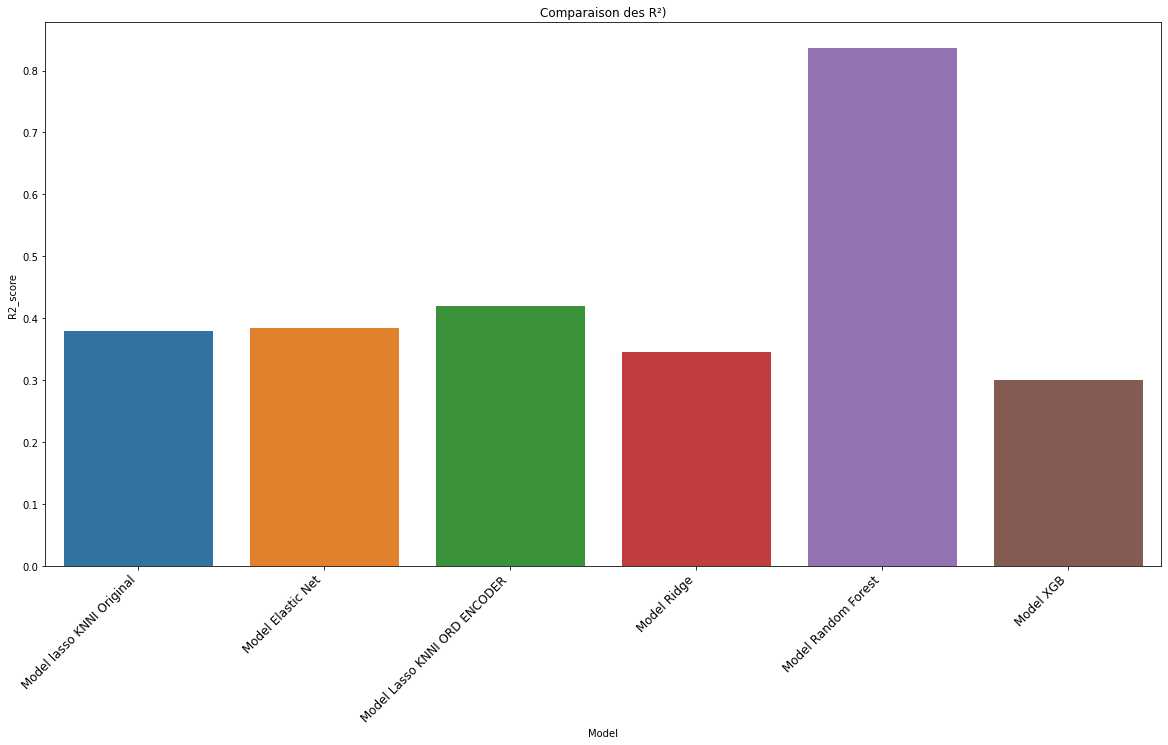

In [81]:
plt.figure(figsize=(20,10))
plt.title('Comparaison des R²)')
chart = sns.barplot(x = Data_Score['Model'],
           y = Data_Score['R2_score'])
chart.set_xticklabels(labels = Data_Score['Model'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

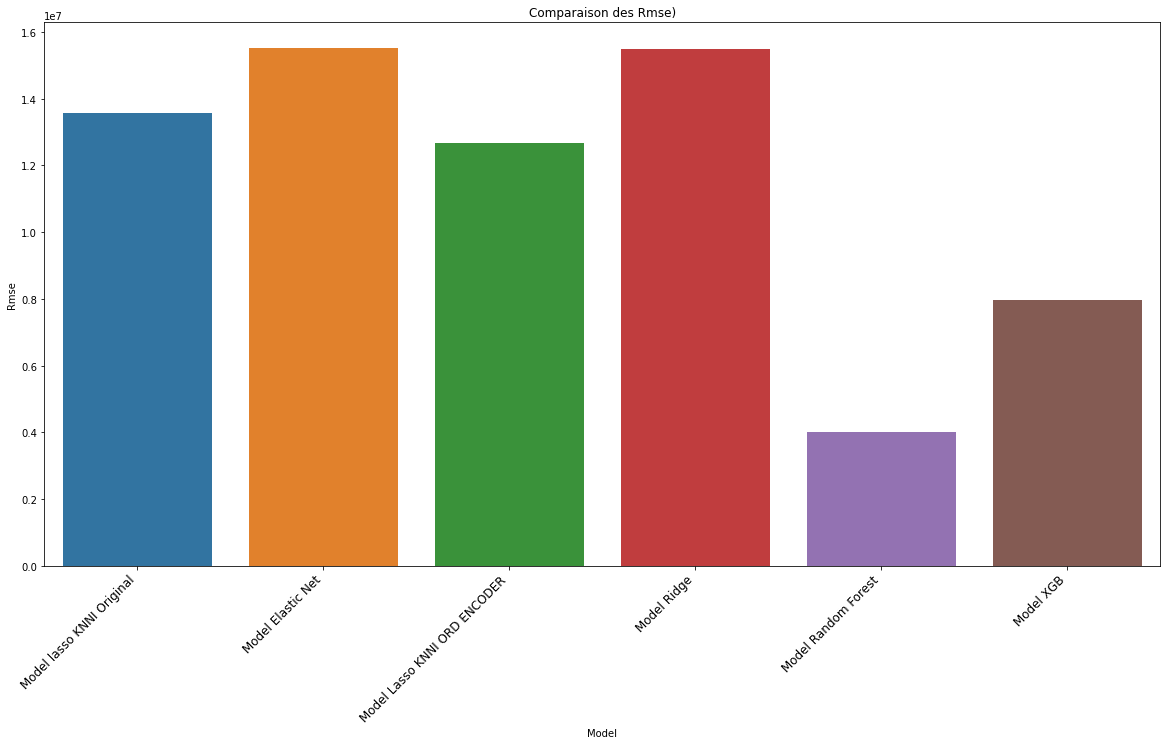

In [82]:
plt.figure(figsize=(20,10))
plt.title('Comparaison des Rmse)')
chart = sns.barplot(x = Data_Score['Model'],
           y = Data_Score['Rmse'])
chart.set_xticklabels(labels = Data_Score['Model'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

On obtient les meilleurs scores avec le modèle RandomForest Regressor. C'est le modèle que l'on selectionnera. 

# Milestone 5 : Analyse de la « feature importance » globale et locale

On regarde l'importance des features sur nos prédictions.

## Ridge feature importance

In [83]:
from  sklearn.linear_model import Ridge

In [84]:
Ridge_dict ={}
Ridge_dict["Variable"] = []
Ridge_dict["Score"] = []

In [85]:
for var, score in zip(Features, Ridge_Trained_OHE .coef_[0]):
    Ridge_dict ["Variable"].append(var)
    Ridge_dict ["Score"].append(score)

In [86]:
Ridge_feature_importance = pd.DataFrame(Ridge_dict , columns = ["Score"], index =Ridge_dict ["Variable"]).sort_values(by="Score", ascending = False, axis=0)
Ridge_feature_importance.head(30)

,Score
PrimaryPropertyType,5.325794e-01
LargestPropertyUseType,3.630256e-01
SteamUse(kBtu) %,2.233593e-01
ThirdLargestPropertyUseType,1.040264e-01
NaturalGas(kBtu) %,7.275770e-02
more_one_building,6.637388e-02
CouncilDistrictCode,5.751267e-02
SecondLargestPropertyUseType,5.639032e-02
x0_downtown,4.288139e-02
NumberofFloors,3.566830e-02


 Le modèles Ridge ayant une score de R² faible il est difficile d'interpréter ces résultats car il y a beaucoup d'erreurs de prédiction.
 
Les variables les plus importantes sont les variables "Use Type" ainsi que les proprortions des énergies.

In [87]:
rfi  = Ridge_feature_importance.reset_index()

In [88]:
rfi  

,index,Score
0,PrimaryPropertyType,5.325794e-01
1,LargestPropertyUseType,3.630256e-01
2,SteamUse(kBtu) %,2.233593e-01
3,ThirdLargestPropertyUseType,1.040264e-01
4,NaturalGas(kBtu) %,7.275770e-02
5,more_one_building,6.637388e-02
6,CouncilDistrictCode,5.751267e-02
7,SecondLargestPropertyUseType,5.639032e-02
8,x0_downtown,4.288139e-02
9,NumberofFloors,3.566830e-02


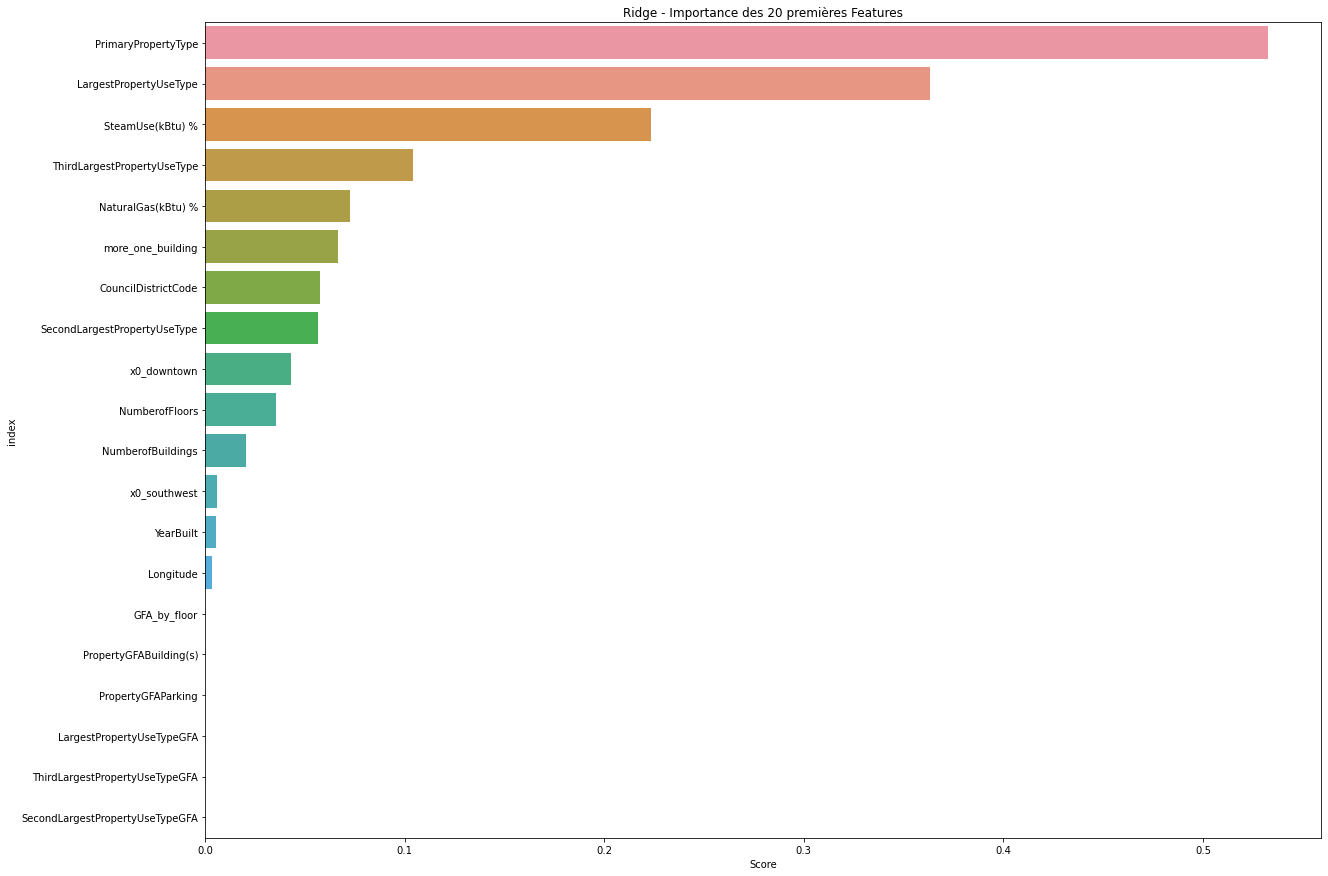

In [89]:
plt.figure(figsize=(20,15))
plt.title('Ridge - Importance des 20 premières Features')
sns.barplot(y = rfi ['index'].head(20),
            x = rfi ['Score'].head(20))
plt.show()

In [90]:
import shap

Importance des features.

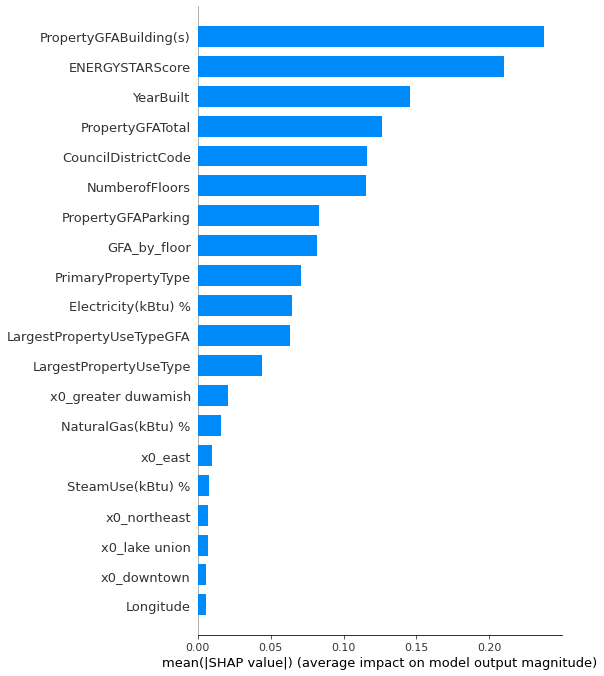

In [91]:
explainer = shap.explainers.Linear(Ridge_Trained_OHE, masker = Data_use [Features])
shap_values = explainer.shap_values(Data_use [Features])
shap.summary_plot(shap_values, Data_use [Features], plot_type='bar')

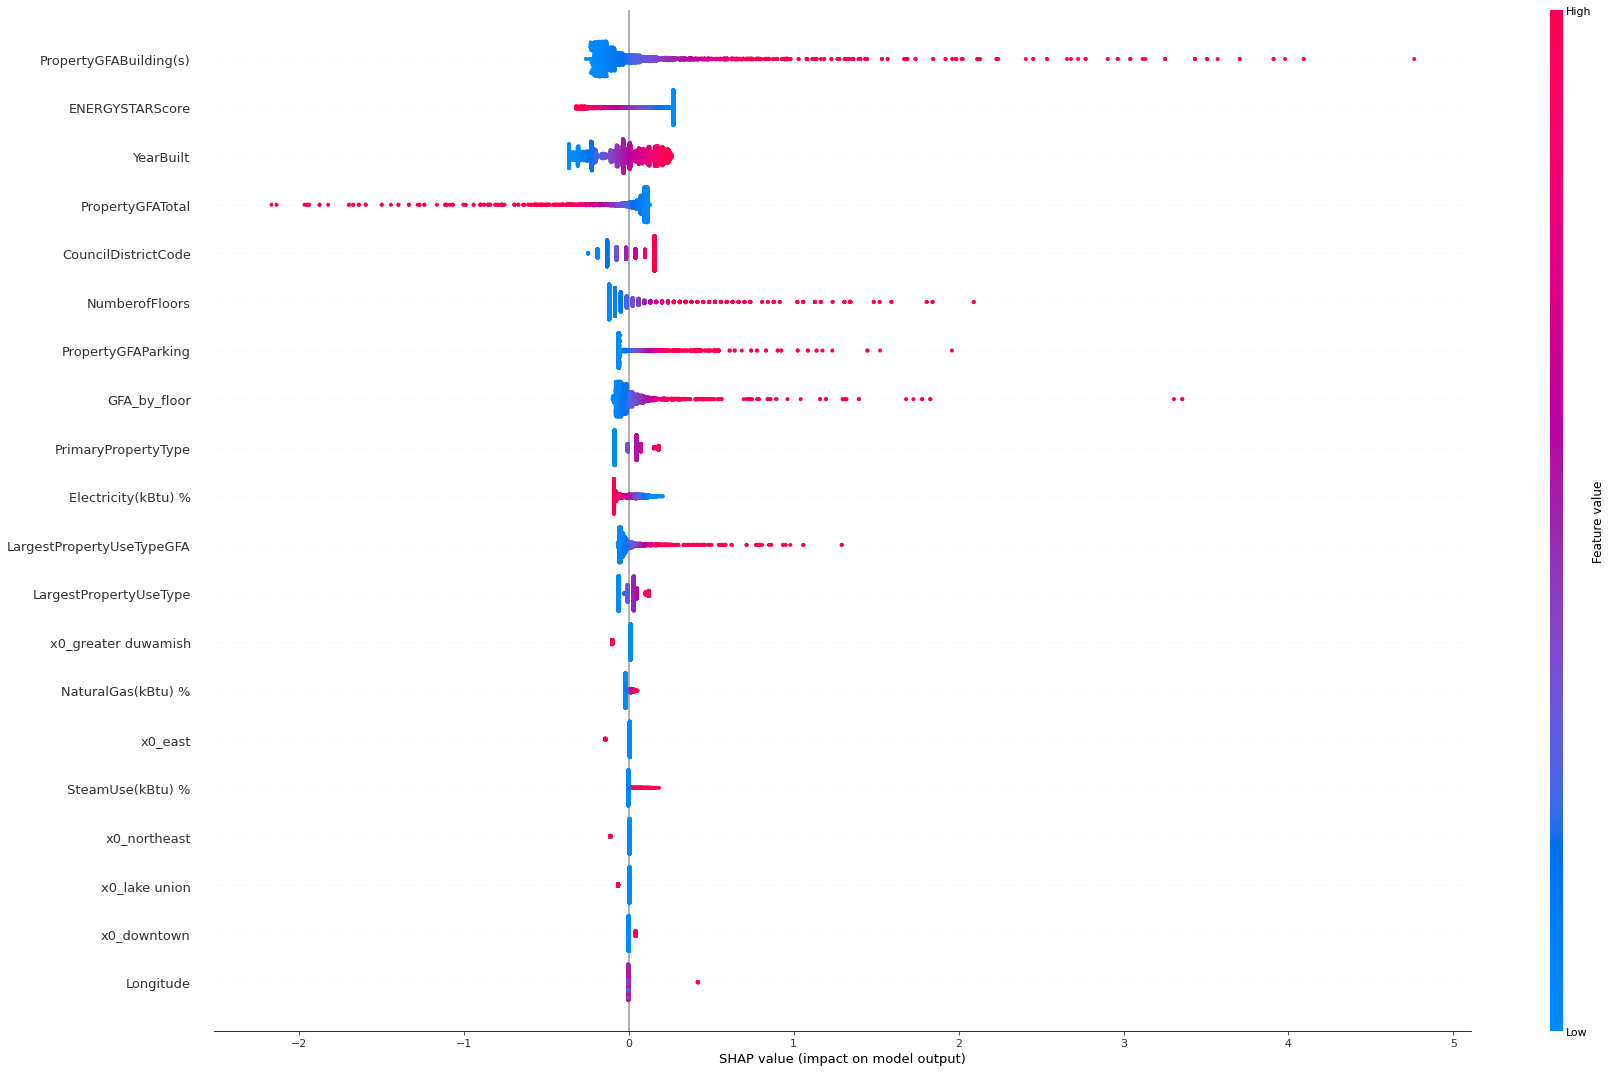

In [92]:
shap.summary_plot(shap_values,  Data_use [Features],plot_size =(25,15))

On confirme graphiquement nos observations théoriques. 

# Random Forest 

In [93]:
RF_dict = {}
RF_dict["Variable"] = []
RF_dict["Score"] = []


In [94]:
for var, score in zip(Features, RandomF_Trained_OHE.feature_importances_):
    RF_dict["Variable"].append(var)
    RF_dict["Score"].append(score)

rf_feature_importance = pd.DataFrame(RF_dict, columns = ["Score"], index=RF_dict ["Variable"]).sort_values(by="Score", ascending = False, axis=0)
##rf_feature_importance = rf_feature_importance.drop_duplicates()
rf_feature_importance.head(30)

,Score
PropertyGFABuilding(s),0.209345
ENERGYSTARScore,0.096054
LargestPropertyUseTypeGFA,0.087316
PropertyGFATotal,0.084881
Longitude,0.080798
Latitude,0.070402
GFA_by_floor,0.060883
NaturalGas(kBtu) %,0.050447
YearBuilt,0.049176
Electricity(kBtu) %,0.043573


Avec le random forest Regressor on a des résultats plus précis. Les features surfaces et energy score sont les plus importantes dans la regression.

In [95]:
RForest = rf_feature_importance.reset_index()

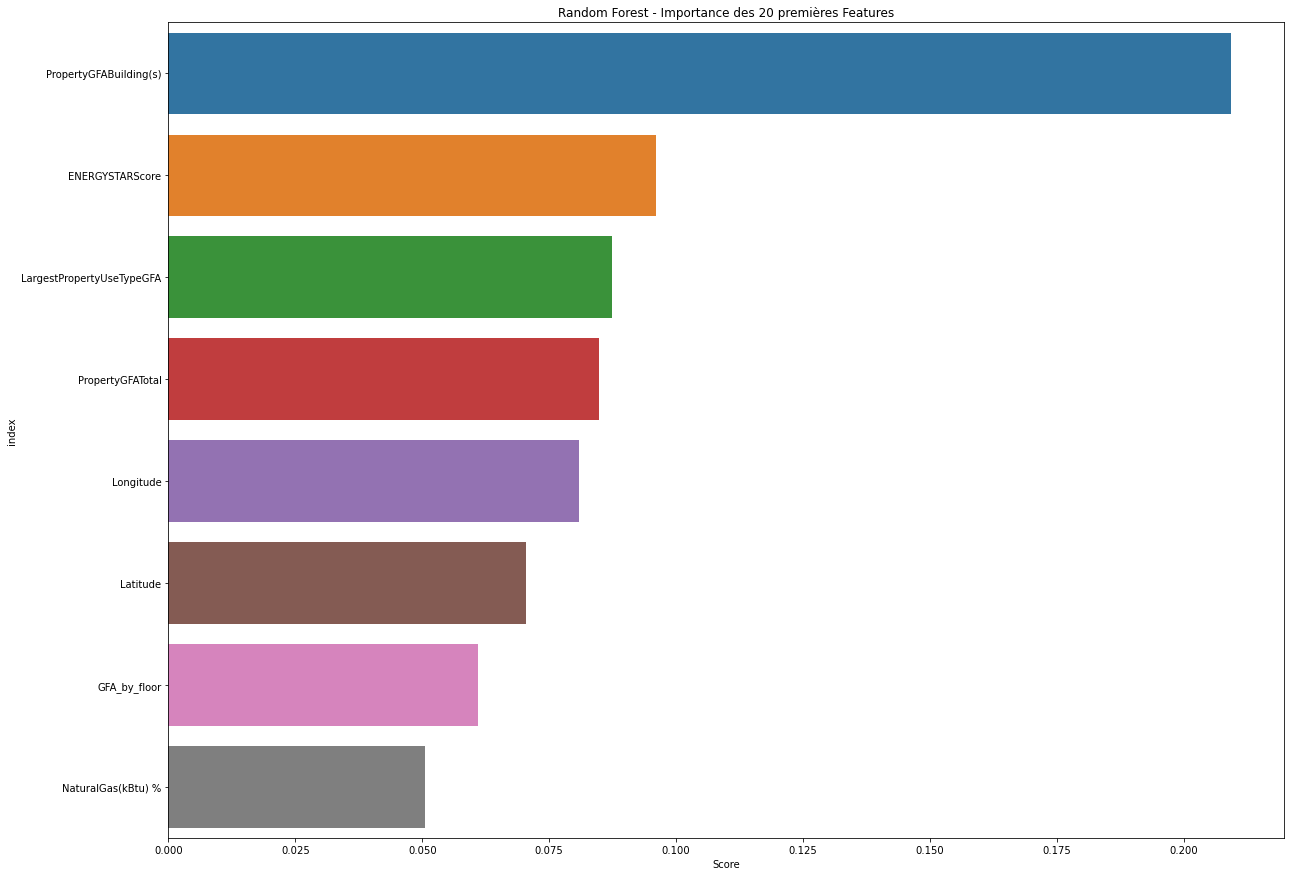

In [96]:
plt.figure(figsize=(20,15))
plt.title('Random Forest - Importance des 20 premières Features')
sns.barplot(y = RForest['index'].head(8),
            x = RForest['Score'].head(8))
plt.show()

In [97]:
RForest

,index,Score
0,PropertyGFABuilding(s),0.209345
1,ENERGYSTARScore,0.096054
2,LargestPropertyUseTypeGFA,0.087316
3,PropertyGFATotal,0.084881
4,Longitude,0.080798
5,Latitude,0.070402
6,GFA_by_floor,0.060883
7,NaturalGas(kBtu) %,0.050447
8,YearBuilt,0.049176
9,Electricity(kBtu) %,0.043573


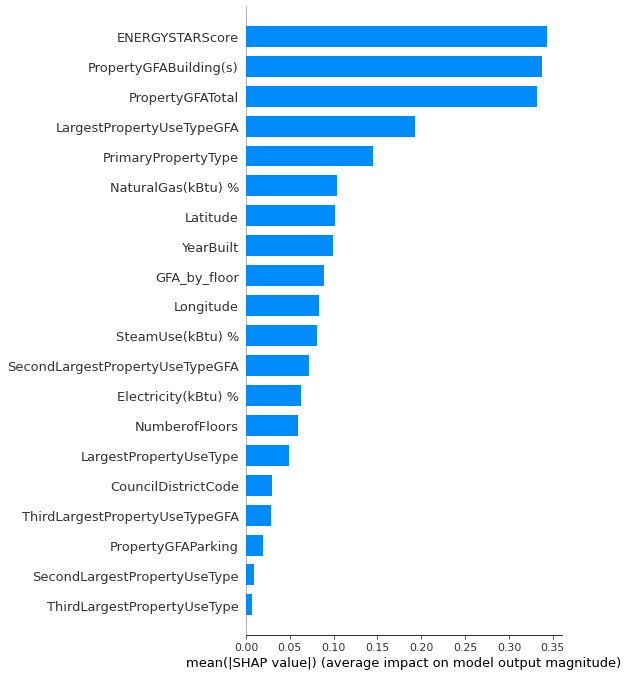

In [98]:
explainer = shap.TreeExplainer(RandomF_Trained_OHE )
shap_values = explainer.shap_values(Data_use [Features],approximate=True, check_additivity=False)
shap.summary_plot(shap_values, Data_use [Features], plot_type='bar')

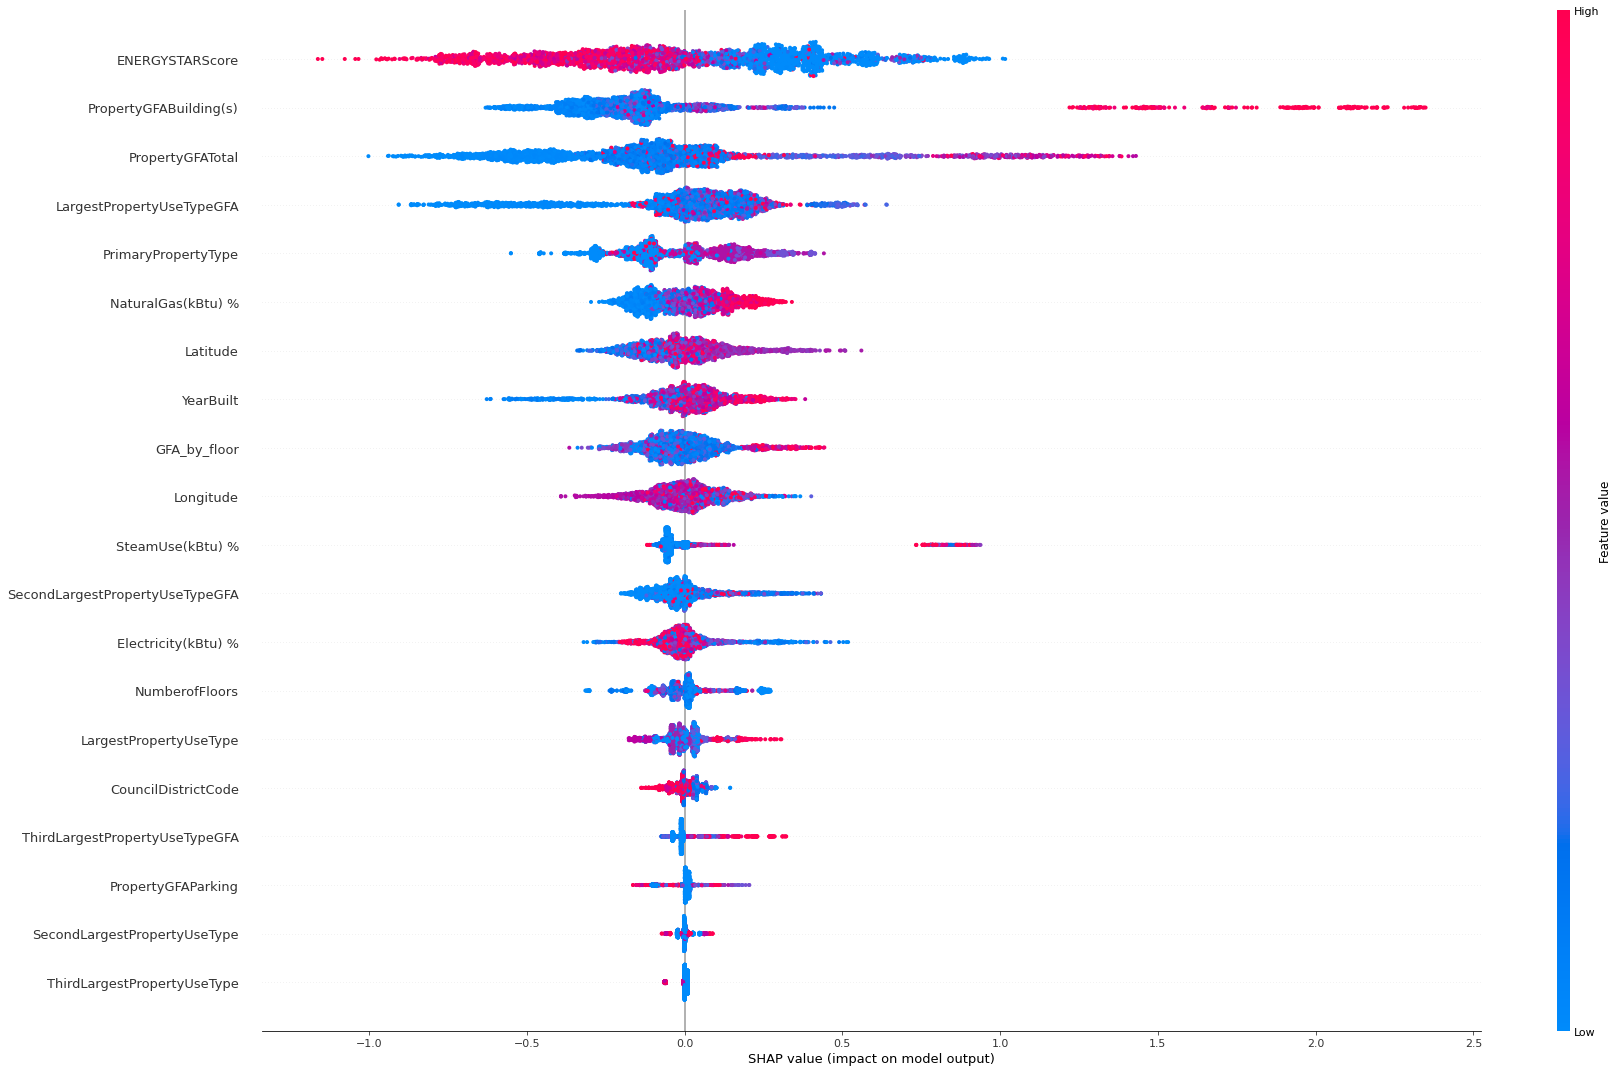

In [99]:
shap.summary_plot(shap_values,  Data_use [Features],plot_size =(25,15))

## OLS

On souhaite utliser une technique pour voir la significativité des variables.

In [100]:
model = sm.OLS(y_train,x_train)
results = model.fit()
print('Impacts des variables',results.summary())

Impacts des variables                                 OLS Regression Results                               
Dep. Variable:     Log SiteEnergyUseWN(kBtu)   R-squared:                       0.544
Model:                                   OLS   Adj. R-squared:                  0.538
Method:                        Least Squares   F-statistic:                     81.04
Date:                       Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                               14:46:06   Log-Likelihood:                -3034.9
No. Observations:                       2480   AIC:                             6144.
Df Residuals:                           2443   BIC:                             6359.
Df Model:                                 36                                         
Covariance Type:                   nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------

L'O.L.S permet de décrire la relation entre les variables d'entrée et la cible. Les features "Use Type" ainsi que les proportions des énergies ont le plus d'impactent sur le résultat.

## Prédiction et Valeurs réelles

In [101]:
x_train, x_test, y_train, y_test = OHE_Train_Test_Split (Data_use, target, Features)

In [102]:
Model_RF_Reg = RandomForestRegressor(max_depth = 10, max_leaf_nodes =  100, n_estimators =  100, random_state = 0)
Model_RF_Reg.fit(x_train ,y_train)
y_Predict = Model_RF_Reg.predict(Data_use [Features])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


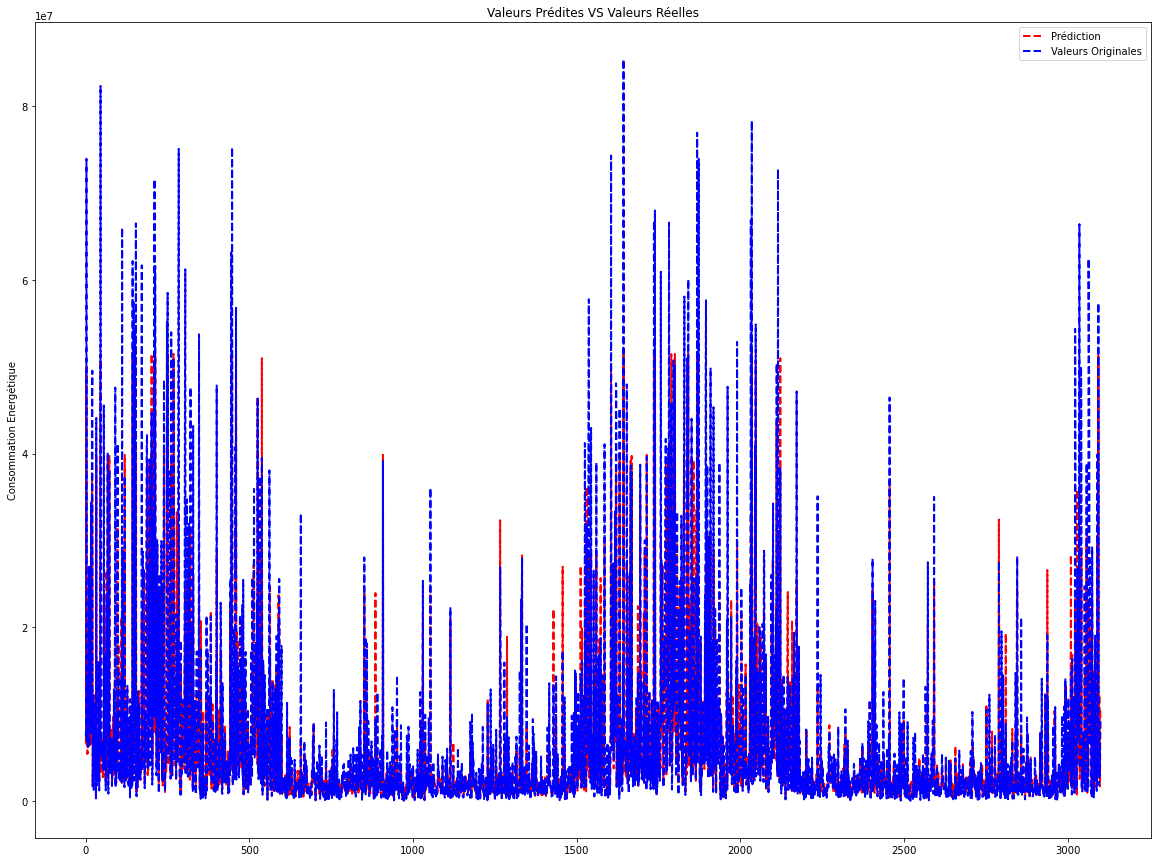

In [103]:
plt.figure(figsize=(20,15))
plt.plot(np.exp(y_Predict), color='red', linestyle='dashed',linewidth=2, markersize=12, label ='Prédiction')
plt.plot(np.exp(Data_use [target]), color='blue', linestyle='dashed',linewidth=2, markersize=12, label ='Valeurs Originales')
plt.ylabel ("Consommation Energétique")
plt.title("Valeurs Prédites VS Valeurs Réelles")
plt.legend()

On a des valeurs prédites et réelles très proches. Ce sont les pics de valeurs qui ont en générale du mal a être prédites.

# Milestone 6 : Analyse de l’influence de l’EnergyStarScore

On teste les modèles sans la feature Energy Star Score

## Lasso 

In [104]:
Features_without_nrj_stars = Features.copy()
Features_without_nrj_stars.remove('ENERGYSTARScore')

In [105]:
lasso_grid = model_ml_HP(Lasso(), parameters_lasso,"r2" ,Data_use , target, Features_without_nrj_stars)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.152 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.088 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-46.288 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.2574786255366, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.9830673367477, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.2529175213501, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.5007703636848, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.1072096486289, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.2574786255366, tolerance: 27.870079892403155


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.152 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.088 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-46.288 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.152 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.9830673367477, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.2529175213501, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.5007703636848, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.1072096486289, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.2574786255366, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.9830673367477, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.2529175213501, tolerance: 2.899976348940089


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.088 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-46.288 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.152 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.253 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.5007703636848, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.1072096486289, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.2574786255366, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 695.9830673367477, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.2529175213501, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.5007703636848, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.1072096486289, tolerance: 0.3057987789163949

[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.088 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-46.288 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.152 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.090 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.4708847561767, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 704.2500091320172, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 733.03481773066, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 730.1481458556507, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.1570400409083, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.4708847561767, tolerance: 27.870079892403155


[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-46.361 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.152 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.090 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.391 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 704.2500091320172, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 733.03481773066, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 730.1481458556507, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.1570400409083, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.4708847561767, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 704.2500091320172, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 733.03481773066, tolerance: 2.899976348940089


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-46.361 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.152 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.090 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-46.361 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.152 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 730.1481458556507, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.1570400409083, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 699.4708847561767, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 704.2500091320172, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 733.03481773066, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 730.1481458556507, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 728.1570400409083, tolerance: 0.3057987789163949
O

[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.090 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-46.361 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.169 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.094 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.387 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 688.5084607035616, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 706.5571938672163, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 744.856658643441, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 542.6138192354101, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 688.5084607035616, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 706.5571938672163, tolerance: 27.940536829574818


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.375 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.169 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.094 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.387 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.375 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 744.856658643441, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.417888021464933, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 542.6138192354101, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 688.5084607035616, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 706.5571938672163, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 744.856658643441, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.417888021464933, tolerance: 0.27870079892403155


[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.169 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.094 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.387 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.375 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.169 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.253 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 542.6138192354101, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 688.5084607035616, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 706.5571938672163, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 744.856658643441, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2633588834528, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 717.5587282815474, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.2562447755918, tolerance: 289.9976348940089


[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.094 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.387 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.375 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.169 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.094 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.843277558451, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.3107681110973, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2633588834528, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 717.5587282815474, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.2562447755918, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.843277558451, tolerance: 27.940536829574818


[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.387 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.375 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.169 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.094 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.387 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.3107681110973, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2633588834528, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 717.5587282815474, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.2562447755918, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.843277558451, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.3107681110973, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2633588834528, tolerance: 0.27870079892403155


[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.375 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.169 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.094 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.387 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.375 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.169 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 717.5587282815474, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.2562447755918, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.843277558451, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.3107681110973, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.29101708876414, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 812.5594355336207, tolerance: 305.7987789163949


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.094 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.387 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.375 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.214 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.231 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.042 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.332 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.214 to

Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.23940361223868, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.62160644070877, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.29101708876414, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 812.5594355336207, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.23940361223868, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.62160644070877, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.29101708876414, tolerance: 2.7940536829574

[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.042 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.332 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.214 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.231 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.042 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.332 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 812.5594355336207, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5328099077603383, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.23940361223868, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.62160644070877, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 507.29101708876414, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 812.5594355336207, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 765.2054826842033, tolerance: 278.7007989240

[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.214 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.231 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.042 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.332 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.214 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 780.3566796835926, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.6695744325001, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 794.7791067592678, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 817.7112546717009, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 765.2054826842033, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 780.3566796835926, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.6695744325001, tolerance: 28.99976348940089
Obje

[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.231 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.042 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.332 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.214 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.231 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 817.7112546717009, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 765.2054826842033, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 780.3566796835926, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.6695744325001, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 794.7791067592678, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 817.7112546717009, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 765.2054826842033, tolerance: 0.27870079892403155
O

[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.042 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.332 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.214 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.231 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.042 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.332 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.6695744325001, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 794.7791067592678, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 817.7112546717009, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.5238841867755, tolerance: 305.7987789163949


[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.382 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.178 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=-0.076 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.288 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.358 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.178 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=-0.076 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.77729419280422, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.5238841867755, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.77729419280422, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.5238841867755, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.959839087779301, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0614001660387657, tolerance: 0.2899976348940089


[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.288 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.358 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.178 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=-0.076 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.288 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.358 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.178 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.076 total 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.77729419280422, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.5238841867755, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 556.4009457125582, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.337974397422, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 751.1560403864977, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.5744588030202, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 864.4262788097607, tolerance: 305.7987789163949
Objec

[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.178 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=-0.076 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.288 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.358 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.178 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=-0.076 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.337974397422, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 751.1560403864977, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.5744588030202, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 864.4262788097607, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 556.4009457125582, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.337974397422, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 751.1560403864977, tolerance: 2.899976348940089
Obje

[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.288 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.358 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.178 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.178 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=-0.076 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.288 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.358 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.196 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.162 total time=   

Objective did not converge. You might want to increase the number of iterations. Duality gap: 556.4009457125582, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.337974397422, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 751.1560403864977, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 781.5744588030202, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 864.4262788097607, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.21518683177123, tolerance: 305.7987789163949


[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.222 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.354 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.196 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.162 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.222 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.354 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.196 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=-0.162 total time=   0.0s
[CV 4/5] END alph

Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.21518683177123, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.21518683177123, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7576210577810798, tolerance: 0.2794053682957482


[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.354 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.196 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.162 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.222 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.354 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.196 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.162 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 498.21518683177123, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.5515536134145, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 308.7843224728754, tolerance: 29.868213941176457


[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.222 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.354 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.196 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.162 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.222 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.354 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.1147876544519, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.5515536134145, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.1471797674792, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 308.7843224728754, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.1147876544519, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.5515536134145, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.1471797674792, tolerance: 0.27870079892403155
Ob

[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.196 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.162 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.222 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.354 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.196 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=-0.162 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.222 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1942374314971858, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.1147876544519, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.5515536134145, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 30.57987789163949


[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.0001;, score=0.354 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.199 total time=   0.0s
[CV 5/5] END

Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.902399242644606, tolerance: 0.3057987789163949


[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.01;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.342 total time=   0.0s
[CV

Objective did not converge. You might want to increase the number of iterations. Duality gap: 386.6683285566919, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 386.6683285566919, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.856915447236133, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 386.6683285566919, tolerance: 0.3057987789163949


[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.199 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.201 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.341 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.110 total time=   0.0s

Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.7142368848705, tolerance: 368.2991041840745


In [106]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {lasso_grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'alpha': 0.001, 'random_state': 0, 'selection': 'random', 'tol': 0.1}]


In [107]:
model_lasso = Lasso(alpha = 0.001, random_state =  0, tol =  0.1, selection = 'random')

In [108]:
lasso_resume, Lasso_Trained = Modele_ML(model_lasso ,Data_use , 
                                        target, Features_without_nrj_stars, 'Model lasso W Energy')

Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.7142368848705, tolerance: 368.2991041840745
Objective did not converge. You might want to increase the number of iterations. Duality gap: 889.5599644149179, tolerance: 347.0199451754974
Objective did not converge. You might want to increase the number of iterations. Duality gap: 946.7876766639281, tolerance: 382.69156590037073
Objective did not converge. You might want to increase the number of iterations. Duality gap: 974.55802566502, tolerance: 364.30443823020954
Objective did not converge. You might want to increase the number of iterations. Duality gap: 943.9770196343051, tolerance: 382.7674828163429
Objective did not converge. You might want to increase the number of iterations. Duality gap: 929.8011260258684, tolerance: 368.3042463460104


mse = 210101546603617.53
rmse = 14494880.013426036
mae = 3290985.438544429
explained_var = 0.41250557715327474
r2_score = 0.3324157229718573
cross_validation_score [1.20650682e-01 3.99656444e-04 5.52176682e-01 3.95919239e-01
 3.31880800e-01] 


In [109]:
Data_add = pd.DataFrame(data = lasso_resume)
Data_Score = Data_Score.append(Data_add )
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
0,Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."
0,Model XGB,6.343379e+13,7964533.44,3399177.33,0.61,0.2997,0.965861,"[0.42489895530396726, -0.07105630352737102, 0....","[15.135169809155679, 13.99907427129371, 14.894..."
0,Model lasso W Energy,2.101015e+14,14494880.01,3290985.44,0.41,0.3324,0.031511,"[0.12065068155127856, 0.0003996564438825123, 0...","[14.89899145131659, 14.782737538605407, 14.829..."


## ElasticNet

In [110]:
ElasticNet_Grid = model_ml_HP(ElasticNet(), parameters_EN,"r2" ,Data_use , target, Features_without_nrj_stars)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.8900140154594, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 700.4691986669552, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.486995632961, tolerance: 289.9976348940089


Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.151 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.088 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.1;, score=-53.032 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.8933677998004, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.3754629088821, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.8900140154594, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 700.4691986669552, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.486995632961, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.8933677998004, tolerance: 27.940536829574818


[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.151 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.088 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.01;, score=-53.032 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.3754629088821, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.8900140154594, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 700.4691986669552, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.486995632961, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.8933677998004, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.3754629088821, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 697.8900140154594, tolerance: 0.27870079892403155


[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.088 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.001;, score=-53.032 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.151 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.088 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 700.4691986669552, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.486995632961, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.8933677998004, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.3754629088821, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 698.8629295344416, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 703.8101293602472, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 732.6015744714196, tolerance: 289.9976348940089


[CV 4/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=cyclic, tol=0.0001;, score=-53.032 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.151 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.090 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=0.391 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.7230219172845, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.4030300865358, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 698.8629295344416, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 703.8101293602472, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 732.6015744714196, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.7230219172845, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.4030300865358, tolerance: 30.57987789163949


[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.1;, score=-53.104 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.151 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.090 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.01;, score=-53.104 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 698.8629295344416, tolerance: 2.7870079892403155


[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.151 total time=   0.0s
[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.090 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.001;, score=-53.104 total time=   0.0s
[CV 1/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.151 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 703.8101293602472, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 732.6015744714196, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.7230219172845, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.4030300865358, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 698.8629295344416, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 703.8101293602472, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 732.6015744714196, tolerance: 0.2899976348940089


[CV 2/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.253 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.7230219172845, tolerance: 0.2794053682957482


[CV 3/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.090 total time=   0.0s
[CV 4/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.0001, random_state=0, selection=random, tol=0.0001;, score=-53.104 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.161 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.091 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.389 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.4030300865358, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.0243114042834, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.2124760049601, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 720.6722921590746, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.5803644378994, tolerance: 305.7987789163949


[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.1;, score=0.367 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.161 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.091 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.389 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.01;, score=0.367 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.161 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.15431726815336, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.0243114042834, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.2124760049601, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 720.6722921590746, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.5803644378994, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.15431726815336, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.0243114042834, tolerance: 2.9868213941176456


[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.091 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.389 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.001;, score=0.367 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.161 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.091 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.2124760049601, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 720.6722921590746, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.5803644378994, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.15431726815336, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.0243114042834, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.2124760049601, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 720.6722921590746, tolerance: 0.2794053682957482


[CV 4/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.389 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=cyclic, tol=0.0001;, score=0.367 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.161 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.092 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.389 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.1;, score=0.367 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 709.7333420935197, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.8157297893342, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.9192017290305, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 738.6537501524438, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.8106660999181, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 709.7333420935197, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.8157297893342, tolerance: 29.868213941176457


[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.161 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.092 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.389 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.01;, score=0.367 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.161 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.9192017290305, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 738.6537501524438, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.8106660999181, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 709.7333420935197, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.8157297893342, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.9192017290305, tolerance: 2.899976348940089


[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.092 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.389 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.001;, score=0.367 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.161 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.092 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 738.6537501524438, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.8106660999181, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 709.7333420935197, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.8157297893342, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.9192017290305, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 738.6537501524438, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 739.8106660999181, tolerance: 0.3057987789163949

[CV 4/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.389 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, selection=random, tol=0.0001;, score=0.367 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.200 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.237 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.058 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.348 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.1;, score=0.387 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.5917387527147, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 797.7594348187594, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.03120312297165, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.34421480092317, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.5917387527147, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 797.7594348187594, tolerance: 30.57987789163949


[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.200 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.237 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.058 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.348 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.01;, score=0.387 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.200 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.03120312297165, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.34421480092317, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 619.5917387527147, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 797.7594348187594, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2172834052510098, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 244.03120312297165, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 220.34421480092317, tolerance: 0.289997634894

[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.237 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.058 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.348 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.001;, score=0.387 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.200 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.237 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.058 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.348 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=cyclic, tol=0.0001;, score=0.387 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.1;, score=0.

Objective did not converge. You might want to increase the number of iterations. Duality gap: 797.7594348187594, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.3628955851459, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.455653142406, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 789.3083765404006, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.4039320761309, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 800.2608394648305, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.3628955851459, tolerance: 27.870079892403155
Objec

[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.200 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.237 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.058 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.348 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.01;, score=0.387 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.200 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.237 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 789.3083765404006, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.4039320761309, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 800.2608394648305, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.3628955851459, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.455653142406, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 789.3083765404006, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.4039320761309, tolerance: 2.7940536829574816


[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.058 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.348 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.001;, score=0.387 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.200 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.237 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.058 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.348 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, selection=random, tol=0.0001;, score=0.387 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 800.2608394648305, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 760.3628955851459, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.455653142406, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 789.3083765404006, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.4039320761309, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 800.2608394648305, tolerance: 0.3057987789163949


[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.184 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.172 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=-0.058 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.1;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.184 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.172 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=-0.058 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 827.8759375444185, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.4243132139867, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 827.8759375444185, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.210944470818276, tolerance: 2.9868213941176456


[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.01;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.184 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.172 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=-0.058 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.001;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.184 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.254193195247353, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.4243132139867, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 827.8759375444185, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.210944470818276, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.254193195247353, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.4243132139867, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 827.8759375444185, tolerance: 0.3057987789163949


[CV 2/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.172 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.058 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=cyclic, tol=0.0001;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.184 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.172 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=-0.058 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.296 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 673.0155409884994, tolerance: 278.7007989240316
Objective did not converge. You might want to increase the number of iterations. Duality gap: 780.944843329066, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.8654205506737, tolerance: 289.9976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.9858971661315, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.9694595570664, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 673.0155409884994, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 780.944843329066, tolerance: 29.868213941176457
Object

[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.1;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.184 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.172 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=-0.058 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.01;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.184 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.9858971661315, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.9694595570664, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 673.0155409884994, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 780.944843329066, tolerance: 2.9868213941176456
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.8654205506737, tolerance: 2.899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.9858971661315, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.9694595570664, tolerance: 3.057987789163949
Obj

[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.172 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=-0.058 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.296 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.001;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.184 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.172 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=-0.058 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.296 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 780.944843329066, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 790.8654205506737, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 806.9858971661315, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 857.9694595570664, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 651.9540319004836, tolerance: 305.7987789163949


[CV 5/5] END alpha=0.1, random_state=0, selection=random, tol=0.0001;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=-0.156 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.225 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.1;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=-0.156 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.225 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 651.9540319004836, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.320631097901014, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 651.9540319004836, tolerance: 3.057987789163949


[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.01;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=-0.156 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.225 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.001;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=-0.156 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.320631097901014, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 651.9540319004836, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.48354725938714, tolerance: 298.6821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.007457052378, tolerance: 279.4053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 869.7458688731858, tolerance: 305.7987789163949


[CV 4/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.225 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=cyclic, tol=0.0001;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=-0.156 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.225 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.1;, score=0.356 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.17846537202502, tolerance: 27.870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.48354725938714, tolerance: 29.868213941176457
Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.8636973295546, tolerance: 28.99976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.007457052378, tolerance: 27.940536829574818
Objective did not converge. You might want to increase the number of iterations. Duality gap: 869.7458688731858, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.17846537202502, tolerance: 2.7870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.48354725938714, tolerance: 2.986821394117645

[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=-0.156 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.225 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.01;, score=0.356 total time=   0.0s
[CV 1/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.118 total time=   0.0s
[CV 2/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.197 total time=   0.0s
[CV 3/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=-0.156 total time=   0.0s
[CV 4/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.225 total time=   0.0s
[CV 5/5] END alpha=1, random_state=0, selection=random, tol=0.001;, score=0.356 total time=   0.0s
[CV 1/5] END 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.007457052378, tolerance: 2.7940536829574816
Objective did not converge. You might want to increase the number of iterations. Duality gap: 869.7458688731858, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.17846537202502, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 500.48354725938714, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.8636973295546, tolerance: 0.2899976348940089
Objective did not converge. You might want to increase the number of iterations. Duality gap: 475.007457052378, tolerance: 0.2794053682957482
Objective did not converge. You might want to increase the number of iterations. Duality gap: 869.7458688731858, tolerance: 0.3057987789163949

[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.1;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.01;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.106 total time=   0.0s


Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.42902347866652, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.42902347866652, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 110.42902347866652, tolerance: 0.3057987789163949


[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=cyclic, tol=0.0001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.1;, score=0.106 total time=   

Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.2441382835427, tolerance: 305.7987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.2441382835427, tolerance: 30.57987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.09761497530167, tolerance: 2.9868213941176456


[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.199 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, selection=random, tol=0.0001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.1;, score=-0.197 total time=   0

Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.2441382835427, tolerance: 3.057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5042479104795348, tolerance: 0.27870079892403155
Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.09761497530167, tolerance: 0.2986821394117646
Objective did not converge. You might want to increase the number of iterations. Duality gap: 599.2441382835427, tolerance: 0.3057987789163949


[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.108 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=-0.197 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.200 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.01;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=0.108 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=0.191 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=-0.197 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=0.200 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, selection=cyclic, tol=0.001;, score=0.342 total time= 

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1627081553854168, tolerance: 0.3057987789163949
Objective did not converge. You might want to increase the number of iterations. Duality gap: 924.7271894080139, tolerance: 368.2991041840745


In [111]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {ElasticNet_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'alpha': 0.001, 'random_state': 0, 'selection': 'random', 'tol': 0.1}]


In [112]:
Model_Elastic = ElasticNet(alpha = 0.001, random_state =  0, tol =  0.1, selection = "random")

In [113]:
ElasticNet_resume, ElasticNet_Trained  = Modele_ML(Model_Elastic,Data_use , target, Features_without_nrj_stars, "Model Elastic Net W Energy")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 988.8921618412037, tolerance: 368.2991041840745
Objective did not converge. You might want to increase the number of iterations. Duality gap: 915.666383040071, tolerance: 347.0199451754974
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1009.6685368934837, tolerance: 382.69156590037073
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1029.518753896282, tolerance: 364.30443823020954
Objective did not converge. You might want to increase the number of iterations. Duality gap: 1002.5388130769594, tolerance: 382.7674828163429
Objective did not converge. You might want to increase the number of iterations. Duality gap: 989.0192074815226, tolerance: 368.3042463460104


mse = 281356342286210.53
rmse = 16773680.046018839
mae = 3412121.1805340215
explained_var = 0.3896187226317296
r2_score = 0.3289560636370794
cross_validation_score [0.14752048 0.04694905 0.53723196 0.37714662 0.32853872] 


In [114]:
Data_add = pd.DataFrame(data = ElasticNet_resume)
Data_Score = Data_Score.append(Data_add )
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
0,Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."
0,Model XGB,6.343379e+13,7964533.44,3399177.33,0.61,0.2997,0.965861,"[0.42489895530396726, -0.07105630352737102, 0....","[15.135169809155679, 13.99907427129371, 14.894..."
0,Model lasso W Energy,2.101015e+14,14494880.01,3290985.44,0.41,0.3324,0.031511,"[0.12065068155127856, 0.0003996564438825123, 0...","[14.89899145131659, 14.782737538605407, 14.829..."
0,Model Elastic Net W Energy,2.813563e+14,16773680.05,3412121.18,0.39,0.3290,0.033686,"[0.14752048228309633, 0.046949052652540346, 0....","[14.828103744902187, 14.718131565565567, 14.75..."


## Ridge 

In [115]:
Ridge_Grid = model_ml_HP(Ridge(), parameters_Ridge,"r2" ,Data_use , target, Features_without_nrj_stars)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.1;, score=-81.297 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=auto, tol=0.01;, s

Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be ac

[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=svd, tol=0.01;, score=-81.297 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.001;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=svd, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=svd, tol=0.001;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=svd, tol=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=svd, tol=0.001;, score=-81.297 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=svd, tol=0.0001;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.001, ran

Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be accurate.
Ill-conditioned matrix (rcond=4.13589e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.84984e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.97014e-18): result may not be accurate.
Ill-conditioned matrix (rcond=3.94585e-18): result may not be accurate.
Ill-conditioned matrix (rcond=5.87761e-18): result may not be ac

[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.001;, score=-81.297 total time=   0.0s
[CV 1/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.001, random_state=0, solver=cholesky, tol=0.0001;, scor

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.001;, score=-80.003 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=auto, tol=0.0001;, score=-80.003 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=svd, tol=0.1;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.01,

Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.


[CV 3/5] END alpha=0.01, random_state=0, solver=svd, tol=0.0001;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=svd, tol=0.0001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=svd, tol=0.0001;, score=-80.003 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.1;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.1;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.1;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.1;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.1;, score=-80.003 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.149 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=cholesky, tol=0.01;, score=0.253 total time=   0.0s
[CV 3/5] E

Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.94485e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.87647e-17): result may not be accurate.
Ill-conditioned matrix (rcond=4.13445e-17): result may not be accurate.
Ill-conditioned matrix (rcond=5.84838e-17): result may not be accurate.
Ill-conditioned matrix (rcond=3.96918e-17): result may not be ac

[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=-0.206 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.226 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.1;, score=0.332 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.108 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.189 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=-0.193 total time=   0.0s
[CV 4/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.215 total time=   0.0s
[CV 5/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.01;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=0.01, random_state=0, solver=lsqr, tol=0.001;, score=0.192 total time=   0.0s
[CV 3/5] END alpha=0.01, random_state=0

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 4/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=auto, tol=0.01;, score=-68.674 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=0.150 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=0.391 total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=auto, tol=0.001;, score=-68.674 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=auto, tol=0.0001;, score=0.150 total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=auto, tol=0.0001;, score=0.253 total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=auto, tol=0.0001;, score=0.075 total time=   0.0s
[CV 4/5] END alpha=0.1, random_stat

[CV 5/5] END alpha=0.1, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.1;, score=nan total time=   0.0s
[CV 1/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 3/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 4/5] END alpha=0.1, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 5/5] END alpha=0.1, random_state=0, solver=lbfgs, tol

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 1/5] END alpha=10, random_state=0, solver=svd, tol=0.1;, score=0.165 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=svd, tol=0.1;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=svd, tol=0.1;, score=0.079 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=svd, tol=0.1;, score=0.383 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=svd, tol=0.1;, score=-1.288 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=svd, tol=0.01;, score=0.165 total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=svd, tol=0.01;, score=0.254 total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=svd, tol=0.01;, score=0.079 total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=svd, tol=0.01;, score=0.383 total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=svd, tol=0.01;, score=-1.288 total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=svd, tol=0.001;, score=0.16

[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.01;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 2/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 3/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 4/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 5/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.001;, score=nan total time=   0.0s
[CV 1/5] END alpha=10, random_state=0, solver=lbfgs, tol=0.0001;,

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

[CV 2/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.221 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.032 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.337 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=auto, tol=0.1;, score=0.338 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.190 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.221 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.032 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.337 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=auto, tol=0.01;, score=0.338 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=auto, tol=0.001;, score=0.190 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=auto, 

[CV 5/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.01;, score=0.336 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.109 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.192 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.198 total time=   0.0s
[CV 5/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.001;, score=0.342 total time=   0.0s
[CV 1/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.106 total time=   0.0s
[CV 2/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.192 total time=   0.0s
[CV 3/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=-0.196 total time=   0.0s
[CV 4/5] END alpha=100, random_state=0, solver=sparse_cg, tol=0.0001;, score=0.198 tota

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 593, in fit
    self.coef_, self.n_iter_ = _ridge_regression(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 397, in _ridge_regression
    raise ValueError("Known solvers are 'sparse_cg', 'cholesky', 'svd'"
ValueError: Known solvers are 'sparse_cg', 'cholesky', 'svd' 'lsqr', 'sag' or 'saga'. Got lbfgs.

Estimator fit failed. The score on this train-test partition for these parameters will b

In [116]:
print(f"Les Hyperparamètres optimisés de notre modèle sont : {Ridge_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèle sont : [{'alpha': 100, 'random_state': 0, 'solver': 'auto', 'tol': 0.1}]


In [117]:
Model_Ridge = Ridge(alpha =  100, random_state = 0, solver = "auto", tol = 0.1)

In [118]:
Ridge_resume, Ridge_Trained  = Modele_ML( Model_Ridge, Data_use , target, Features_without_nrj_stars, "Model Ridge W Energy")

mse = 278759395474778.75
rmse = 16696089.22696506
mae = 3454102.218226798
explained_var = 0.37120579248832875
r2_score = 0.3033777760792199
cross_validation_score [0.129439   0.01115743 0.52229289 0.36832058 0.30292939] 


In [119]:
Data_add = pd.DataFrame(data = Ridge_resume )
Data_Score = Data_Score.append(Data_add )
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
0,Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."
0,Model XGB,6.343379e+13,7964533.44,3399177.33,0.61,0.2997,0.965861,"[0.42489895530396726, -0.07105630352737102, 0....","[15.135169809155679, 13.99907427129371, 14.894..."
0,Model lasso W Energy,2.101015e+14,14494880.01,3290985.44,0.41,0.3324,0.031511,"[0.12065068155127856, 0.0003996564438825123, 0...","[14.89899145131659, 14.782737538605407, 14.829..."
0,Model Elastic Net W Energy,2.813563e+14,16773680.05,3412121.18,0.39,0.3290,0.033686,"[0.14752048228309633, 0.046949052652540346, 0....","[14.828103744902187, 14.718131565565567, 14.75..."
0,Model Ridge W Energy,2.787594e+14,16696089.23,3454102.22,0.37,0.3034,0.004338,"[0.12943899627386823, 0.011157431932345419, 0....","[[14.872180762643474], [14.701052739537579], [..."


## Random Forest 

In [120]:
RF_Grid = model_ml_HP(RandomForestRegressor(), parameters_RF,"r2" ,Data_use , target, Features_without_nrj_stars)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.701 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.646 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.331 total time=   1.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.763 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.838 total time=   1.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.706 total time=   2.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.649 total time=   2.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.329 total time=   2.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.764 total time=   2.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.840 total time=   2.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.704 total time=   4.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.647 total time=   4.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.325 total time=   4.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.764 total time=   4.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.841 total time=   4.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.701 total time=   1.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.646 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.331 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.763 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.838 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.706 total time=   3.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.649 total time=   3.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.329 total time=   2.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.764 total time=   2.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.840 total time=   2.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.704 total time=   3.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.647 total time=   3.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.325 total time=   3.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.764 total time=   3.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=100, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.841 total time=   3.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.701 total time=   1.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.646 total time=   1.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.331 total time=   1.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.763 total time=   1.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.838 total time=   1.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.706 total time=   2.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.649 total time=   2.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.329 total time=   2.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.764 total time=   2.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.840 total time=   2.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.704 total time=   3.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.647 total time=   3.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.325 total time=   4.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.764 total time=   3.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.841 total time=   3.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.701 total time=   1.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.646 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.331 total time=   1.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.763 total time=   1.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.838 total time=   1.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.706 total time=   2.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.649 total time=   2.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.329 total time=   2.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.764 total time=   2.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.840 total time=   2.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.704 total time=   4.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.647 total time=   4.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.325 total time=   3.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.764 total time=   4.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=150, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.841 total time=   4.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.701 total time=   1.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.646 total time=   1.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.331 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.763 total time=   1.2s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=100, random_state=0;, score=0.838 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.706 total time=   2.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.649 total time=   2.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.329 total time=   2.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.764 total time=   3.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=200, random_state=0;, score=0.840 total time=   3.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.704 total time=   3.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.647 total time=   4.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.325 total time=   3.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.764 total time=   4.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=1000, n_estimators=300, random_state=0;, score=0.841 total time=   4.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.701 total time=   1.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.646 total time=   1.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.331 total time=   1.5s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.763 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=100, random_state=0;, score=0.838 total time=   1.3s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.706 total time=   2.7s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.649 total time=   2.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.329 total time=   2.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.764 total time=   2.9s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=200, random_state=0;, score=0.840 total time=   2.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.704 total time=   3.6s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 2/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.647 total time=   3.8s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 3/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.325 total time=   4.0s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 4/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.764 total time=   4.1s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 5/5] END max_depth=200, max_leaf_nodes=2000, n_estimators=300, random_state=0;, score=0.841 total time=   4.4s


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 Fit time: 1.4127 MAE :0.656 (std : +/- 0.349) for {'max_depth': 100, 'max_leaf_nodes': 1000, 'n_estimators': 100, 'random_state': 0}
 Fit time: 2.8636 MAE :0.658 (std : +/- 0.352) for {'max_depth': 100, 'max_leaf_nodes': 1000, 'n_estimators': 200, 'random_state': 0}
 Fit time: 4.4305 MAE :0.656 (std : +/- 0.355) for {'max_depth': 100, 'max_leaf_nodes': 1000, 'n_estimators': 300, 'random_state': 0}
 Fit time: 1.4298 MAE :0.656 (std : +/- 0.349) for {'max_depth': 100, 'max_leaf_nodes': 2000, 'n_estimators': 100, 'random_state': 0}
 Fit time: 2.8528 MAE :0.658 (std : +/- 0.352) for {'max_depth': 100, 'max_leaf_nodes': 2000, 'n_estimators': 200, 'random_state': 0}
 Fit time: 3.6722 MAE :0.656 (std : +/- 0.355) for {'max_depth': 100, 'max_leaf_nodes': 2000, 'n_estimators': 300, 'random_state': 0}
 Fit time: 1.2924 MAE :0.656 (std : +/- 0.349) for {'max_depth': 150, 'max_leaf_nodes': 1000, 'n_estimators': 100, 'random_state': 0}
 Fit time: 2.5826 MAE :0.658 (std : +/- 0.352) for {'max_depth

In [121]:
print(f"Les Hyperparamètres optimisés de notre modèles sont : {RF_Grid['Best Params']}")

Les Hyperparamètres optimisés de notre modèles sont : [{'max_depth': 100, 'max_leaf_nodes': 2000, 'n_estimators': 200, 'random_state': 0}]


In [122]:
Model_RF_Reg = RandomForestRegressor(max_depth = 100, max_leaf_nodes =  2000, n_estimators =  200, random_state = 0)

In [123]:
RandomF_resume, RandomF_Trained  = Modele_ML(Model_RF_Reg ,Data_use , target, Features_without_nrj_stars, "Model Random Forest W Energy")

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


mse = 21218413984165.074
rmse = 4606344.970165074
mae = 1535716.8644350679
explained_var = 0.8161459124898229
r2_score = 0.8126883361668453
cross_validation_score [0.61103492 0.52831831 0.80876111 0.85214229 0.81113375] 


In [124]:
Data_add = pd.DataFrame(data = RandomF_resume)
Data_Score = Data_Score.append(Data_add )
Data_Score

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
0,Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."
0,Model XGB,6.343379e+13,7964533.44,3399177.33,0.61,0.2997,0.965861,"[0.42489895530396726, -0.07105630352737102, 0....","[15.135169809155679, 13.99907427129371, 14.894..."
0,Model lasso W Energy,2.101015e+14,14494880.01,3290985.44,0.41,0.3324,0.031511,"[0.12065068155127856, 0.0003996564438825123, 0...","[14.89899145131659, 14.782737538605407, 14.829..."
0,Model Elastic Net W Energy,2.813563e+14,16773680.05,3412121.18,0.39,0.3290,0.033686,"[0.14752048228309633, 0.046949052652540346, 0....","[14.828103744902187, 14.718131565565567, 14.75..."
0,Model Ridge W Energy,2.787594e+14,16696089.23,3454102.22,0.37,0.3034,0.004338,"[0.12943899627386823, 0.011157431932345419, 0....","[[14.872180762643474], [14.701052739537579], [..."
0,Model Random Forest W Energy,2.121841e+13,4606344.97,1535716.86,0.82,0.8127,3.271651,"[0.6110349185704433, 0.5283183114501001, 0.808...","[14.907046876639967, 13.889805496375594, 14.74..."


In [125]:
Data_Score = Data_Score[Data_Score["Model"] != "Model XGB"]
Data_Score 

,Model,Mse,Rmse,Mae,Explained_var,R2_score,Time Fit,Cross validation score,Prédiction
0,Model lasso KNNI Original,1.842541e+14,13574021.44,3191686.86,0.48,0.3786,0.191162,"[0.13897227071490925, 0.06578413644458803, 0.5...","[15.051895146678145, 14.717838194655155, 14.68..."
0,Model Elastic Net,2.406118e+14,15511665.25,3275453.51,0.45,0.3836,0.105675,"[0.18608811079619658, 0.09838589608851267, 0.5...","[15.000071271783815, 14.594557588895684, 14.56..."
0,Model Lasso KNNI ORD ENCODER,1.607132e+14,12677269.12,3091471.59,0.48,0.4195,0.073574,"[0.2187099189910734, 0.15273908454754903, 0.57...","[15.016664146786031, 14.627496472669295, 14.60..."
0,Model Ridge,2.397559e+14,15484054.35,3342891.84,0.42,0.3453,0.010677,"[0.15579413707388434, 0.050510021297211494, 0....","[[15.065560418811621], [14.570386205484848], [..."
0,Model Random Forest,1.617447e+13,4021749.93,1408838.72,0.84,0.8362,3.005705,"[0.672844069820147, 0.6423816514873144, 0.8336...","[14.934292804035447, 13.84944401947992, 14.442..."
0,Model lasso W Energy,2.101015e+14,14494880.01,3290985.44,0.41,0.3324,0.031511,"[0.12065068155127856, 0.0003996564438825123, 0...","[14.89899145131659, 14.782737538605407, 14.829..."
0,Model Elastic Net W Energy,2.813563e+14,16773680.05,3412121.18,0.39,0.3290,0.033686,"[0.14752048228309633, 0.046949052652540346, 0....","[14.828103744902187, 14.718131565565567, 14.75..."
0,Model Ridge W Energy,2.787594e+14,16696089.23,3454102.22,0.37,0.3034,0.004338,"[0.12943899627386823, 0.011157431932345419, 0....","[[14.872180762643474], [14.701052739537579], [..."
0,Model Random Forest W Energy,2.121841e+13,4606344.97,1535716.86,0.82,0.8127,3.271651,"[0.6110349185704433, 0.5283183114501001, 0.808...","[14.907046876639967, 13.889805496375594, 14.74..."


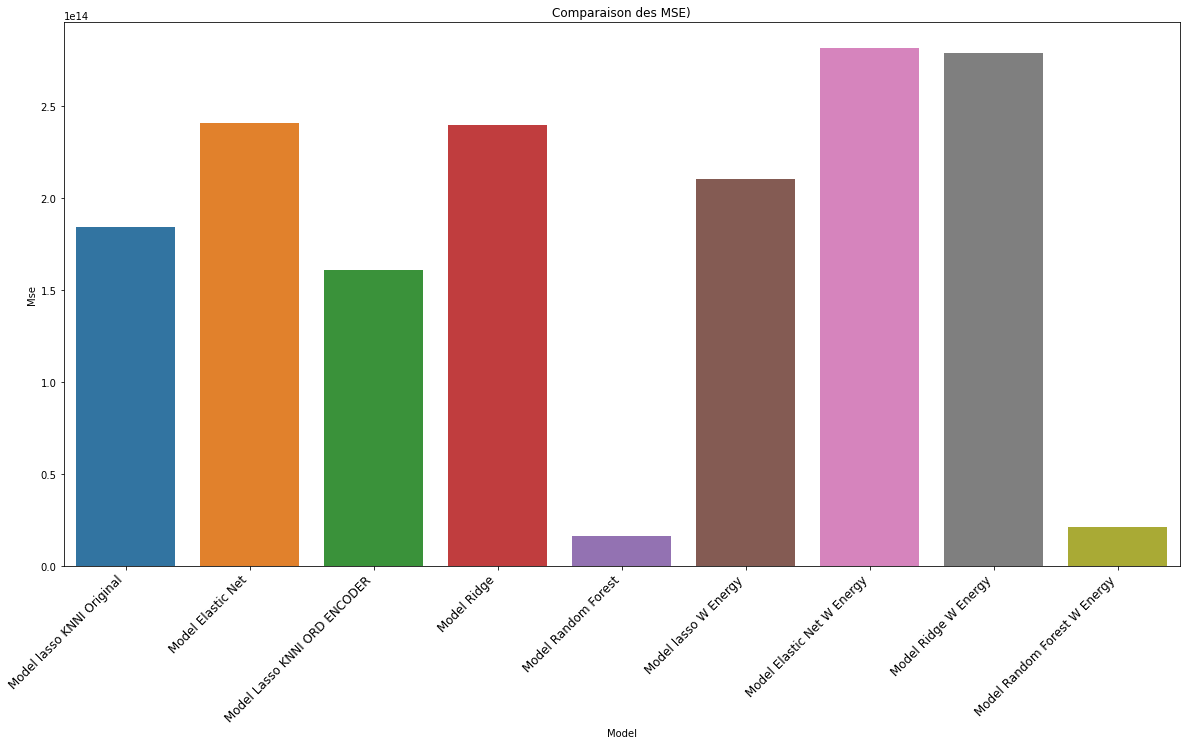

In [126]:
plt.figure(figsize=(20,10))
plt.title('Comparaison des MSE)')
chart = sns.barplot(x = Data_Score['Model'],
           y = Data_Score['Mse'])
chart.set_xticklabels(labels = Data_Score['Model'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

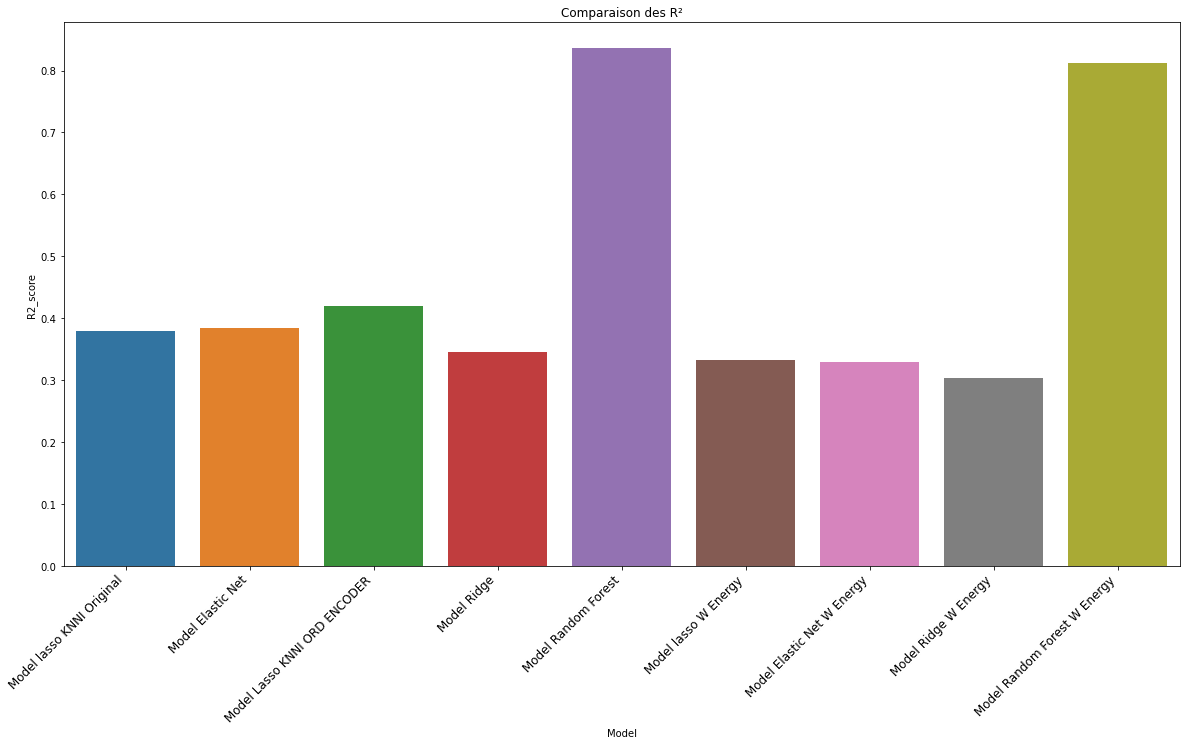

In [127]:
plt.figure(figsize=(20,10))
plt.title('Comparaison des R²')
chart = sns.barplot(x = Data_Score['Model'],
           y = Data_Score['R2_score'])
chart.set_xticklabels(labels = Data_Score['Model'], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
ax = plt.gca()
plt.show()

On obtient des scores de métriques R² plus bas  sans la feature "EnergyStar Score" ainsi que des scores d'erreurs plus élevé sans.